# Preamble

In [7]:
# Imports
## General
import numpy as np
import pickle as pkl
import json
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import time
import datetime
import sys

## In order to run calculations on AWS GPU, need to explicitly specify CUDA lib directory in the environment variables
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/sagemaker-user/.conda/envs/mlds_gpu"

## Data manipulation and preprocessing
import pandas as pd
import boto3
from sklearn.preprocessing import StandardScaler, FunctionTransformer,LabelEncoder, MinMaxScaler,OrdinalEncoder
#import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, MissingIndicator
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy import sparse
from tensorflow.keras.layers import StringLookup, Normalization

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

## Modelling
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Concatenate, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import tensorflow as tf

## Import DeepCTR code
## This is done by cloning the github repository instead of installing with pip. This is because of an incompatibility issue
## with TF 2.14 that I had to manually fix in the DeepCTR code
deepctr_path = '/home/sagemaker-user/drl-ad-personalization/DeepCTR'
if deepctr_path not in sys.path:
    sys.path.append(deepctr_path)

from deepctr.models.fnn import FNN
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from deepctr.models.pnn import PNN
from deepctr.models.wdl import WDL
from deepctr.models.deepfm import DeepFM
from deepctr.models.autoint import AutoInt
from deepctr.models.fgcnn import FGCNN

In [2]:
gpu_devices = tf.config.list_physical_devices('GPU')
gpu_devices

2024-08-07 09:15:07.158717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 09:15:07.508637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 09:15:07.510652: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Introduction


The global digital advertising market is worth approximately \\$602 billion today. Due to the increasing rate of of online participation since the 
COVID-19 pandemic, this number has been rapidly increasing and is expected to reach \\$871 billion by the end of 2027 \citep{RefWorks:emarketer2023digital}.
Many of the of the major Ad platforms such as Google, Facebook and Amazon operate on a cost-per-user-engagement pricing model, which usually means that 
advertisers get charged for every time a user clicks on an advertisment. This means that these platforms are incentivized to make sure that the content 
shown to each user is as relevent as possible in order to maximize the number of clicks in the long term. Attaining accurate Click-Through Rate (CTR) 
prediction is a necessary first step for Ad persionalization, which is why study of CTR prediction methods have been an extremely active part of 
Machine Learning research over the past through years.

Initially, shallow prediction methods such as Logistic Regression, Factorization Machines (Rendel, 2020) and Field-Aware Factorization 
Machines \citep{RefWorks:juan2016field-aware} have been used for CTR prediction. However, these methods have often been shown to be unable to capture the 
higher order feature interactions in the sparse multi-value categorical Ad Marketplace datasets \citep{RefWorks:zhang2021deep}. Since then, Deep Learning methods have been 
shown to show superior predictive ability on these datasets. The focus of my reasearch project is therefore to explore the merits of different Deep 
Learning architechtures for click-through rate prediction.

A number of Deep Learning models have been proposed for CTR prediction, some of which will be explored in this report. Each of these models
outperform their shallow counterparts in terms of predictive ability. In a static environment, these models are able to serve the CTR prediction
function of Ad personalization, but in a dynamic environment, the model must be able to adapt to the changing user preferences. This is where
Reinforcement Learning comes in. Reinforcement Learning is a type of Machine Learning that is used to make a sequence of decisions in an environment
in order to maximize some notion of cumulative reward. In the context of Ad personalization, the environment is composed of the user, the Ad platform
and the advertisments, whereas the reward is the users' engagement with the advertisments and with the Ad platform.


As outlined in the Feasibility secition of my Milestone 3 submission, I have segmented the work over the next few weeks according to the following timeline

![](figures/timeline.png)

Below I proceed by structuring my response according to the following sections
- General Background to Deep CTR and Deep Renforcement Learning
- Data exploration, preprocessing and environment setup
- Model Introduction, Replication and Experimentation

Please note that this notebook illustrates my current work in progress, and certain sections are far from finished. I have also concurrently begun sections of my final write up using the LaTeX template provided. This is available along with the rest of my code in the following Github repository: https://github.com/martinbatek/drl-ad-personalization

# Background

## Deep CTR Prediction

In their respective surveys on the use of Deep Learning methods for CTR prediction, (Gu, 2021) and (Zhang et al., 2021) outline the 
problem of CTR prediction as one that essentially boils down to a binary (click/no-click) classification problem utilizing user/ad-view event level 
online session records. The goal of CTR prediction is to predict the probability of a user clicking on an advertisment given the information available
about the user, advertisment and the context in which the advertisement is shown. Suppose that $\mathbf{x} \in \mathbb{R}^n$
is a vector of features that describes the user, ad and platform for a given instance, and
$y \in \{0, 1\}$ is the binary label indicating whether the user clicked on the ad or not. The goal of CTR prediction is to learn a function
$f: \mathbb{R}^n \rightarrow (0,1)$ such that:

$$
f(\mathbf{x}) = \mathbb{P}(y = 1 | \mathbf{x}) = \mathbb{P}(\text{click}| \mathbf{x})
$$

In other words, for a given set of features $\mathbf{x}$, the model should output the probability that the user will click on the ad.
A defining characteristic for this type of data is that many of the features are multi-value categories with a high degree of of cardinality \citep{RefWorks:he2017neural}. 
This in turn means that the ad marketplace datasets used for CTR predictions can be extremely sparse, which increases the difficulty of the classification problem at 
hand \citep{RefWorks:gu2021ad}.

A key requirement for CTR modelling is therefore working out which of the many sparse features and feature 
interactions (combinations of two or more features) are significant for determining the correct prediction 
(Gu, 2021). Factorization Machines (Rendle, 2010) and Field-aware Factorization Machines (Juan et al., 2016) 
were popularized shallow modelling methods that explicitly account for first order interactions between features. 
However, these techniques do not capture higher order interactions (combinations of three or more features) and 
have thus been known to perform poorly in scenarios with highly sparse data (Zhang et al., 2021). Since 2015 the 
research cummunity has been increasingly turning to Deep Learning techniques to enhance prior CTR prediction 
techniques (such as in the case of DeepFM (Guo et al., 2017)), as well as to develop novel approaches. Neural based 
network models excel at simulataneoulsy extracting high-order and low-order feature interations virtue to the use 
of pooling layers, multiple hidden layers and activation units (Gu, 2021). Due the aforementioned importance of 
feature interation modelling, a number of Feature Interaction Operator layers have been developed to explicitly 
capture the key combinations of features. These layers are then typically incorporated with a supplimentary Deep 
Neural Network in a single or dual tower architecture, as shown in the Figure below:

![DNN_Architecture](figures/single_dual_dnn.png)


Feature Interaction Operators can be categorized as either Product Operators, Convolutional Operators or Attention Operators. Product Operators such as the Product-based Neural Network (PNN) (Qu et al., 2016), Neural Factorization Machines (NFM) (He & Chua, 2017), Deep and Cross Network (Wang et al., 2017) and Gated Deep Cross Network (GDCN) (Wang, F. et al., 2023) introduce a product layer between the categorical feature embedding layer and the rest of the neural network in order to explicitly model the important feature interactions. Convolutional Operators such as the Convolutional Click Prediction Model (CCPM) (Liu et al., 2015) utilized convolution, pooling and non-linear activation in order to calculate arbitrary-order interactions. Finally, Attention Operators such as Attentional Factorization Machines (AFM) (Xiao et al., 2017), AutoInt (Song et al., 2019) and Interpretable CTR prediction model with Hierarchical Attention (InterHAt) (Li et al., 2020) utilize the attention mechanism to enable different feature interactions to contribute differently to the prediction.

## Deep Reinforcement Learning

In their survey, (Wang, X. et al., 2024) describe how deep reinforcement learning combines the aforementioned feature extraction capabilities of DNN’s with the decision-making capability of reinforcement learning, which aims to learn an optimal state-action policy which maximizes the expected reward gained in a given environment. In the context of recommendation systems, a significant amount of research has been dedicated to formulating the recommendation problem as a Contextual Multi-Armed Bandit (MAB) problem setting, where the context consists of user, site and item features (Bouneffouf, Bouzeghoub & Gancarski, 2012; Li, L. et al., 2010; Zeng et al., 2016). However, a shortcoming for the MAB approach is that it does not explicitly model the future expected reward for the policy, which may be detrimental in the longer term (Zheng et al., 2018). Markov Decision Process (MDP) models solve for this issue by modelling the state-action progression as a Markov Process, allowing for the stochastic valuation of the future potential rewards for a given recommendation policy (Lu & Yang, 2016; Mahmood & Ricci, 2007). DRN (Zheng et al., 2018) is a MDP framework that leverages a Deep Neural Network to approximate the expected total user response for each recommendation at each state. The two major advantages of DRN are firstly that it is composed on the basis of a continuous state and action representation, meaning that it can be scaled to large and sparse datasets, and secondly that the proposed reward function consists of both the immediate reward (user click) as well as the future expected reward (long term user engagement), thereby allowing for better recommendations over a user’s lifetime.

# Data Exploration, Caching, Preprocessing pipeline

## Data Exploration

TBD - Include data Exploration sections from Milestone 2

## Load benchmark datasets as tf.datasets

### KDD12

In [3]:
# Load the kdd12_train dataset
kdd12_train = tf.data.experimental.make_csv_dataset(
    "data/kdd12/train_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

2024-08-07 09:17:31.653256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 09:17:31.657087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 09:17:31.660367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
# Load the kdd12_train dataset
kdd12_val = tf.data.experimental.make_csv_dataset(
    "data/kdd12/test_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [13]:
# Print time taken to iterate through 256 records 
start_time = datetime.datetime.now()
i = 0
for element in kdd12_train.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records train:",end_time-start_time)

start_time = datetime.datetime.now()
i = 0
for element in kdd12_val.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records val:",end_time-start_time)

Time taken 256 records train: 0:00:00.107135
Time taken 256 records val: 0:00:00.122853


### Avazu

In [14]:
column_defaults=[
    'string',
    'int32',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]
avazu_train = tf.data.experimental.make_csv_dataset(
    "data/avazu/train_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [15]:
column_defaults=[
    'string',
    'int32',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]

# Load the Avazu train dataset
avazu_val = tf.data.experimental.make_csv_dataset(
    "data/avazu/test_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [16]:
# Drop ID variable
def drop_id(features, label):
    out_features = features.copy()
    del out_features['id']
    return out_features, label

In [17]:
avazu_train = avazu_train.map(drop_id)
avazu_val = avazu_val.map(drop_id)

In [18]:
# Print time taken to iterate through 256 records 
start_time = datetime.datetime.now()
i = 0
for element in avazu_train.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records train:",end_time-start_time)

start_time = datetime.datetime.now()
i = 0
for element in avazu_val.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records val:",end_time-start_time)

Time taken 256 records train: 0:00:00.185129
Time taken 256 records val: 0:00:00.184971


### Criteo

In [19]:
# Load the Criteo train dataset

column_defaults = ['int32'] + 13*['int32'] + 26*['string']

criteo_train = tf.data.experimental.make_csv_dataset(
    "data/criteo/train_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    label_name='click',
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=False,
    ignore_errors=True
)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [20]:
# Load the Criteo train dataset

column_defaults = ['int32'] + 13*['int32'] + 26*['string']

criteo_val = tf.data.experimental.make_csv_dataset(
    "data/criteo/test_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    label_name='click',
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=False,
    ignore_errors=True
)

In [21]:
# Print time taken to iterate through 256 records 
start_time = datetime.datetime.now()
i = 0
for element in criteo_train.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records train:",end_time-start_time)

start_time = datetime.datetime.now()
i = 0
for element in criteo_val.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records val:",end_time-start_time)

Time taken 256 records train: 0:00:00.252945
Time taken 256 records val: 0:00:00.409613


## Preprocessing

Below I construct the preprocessing pipeline for the tensorflow datasets on the basis of the exploration functions above. I proceed by:

- Enconding the sparse catecorically features using the Ordinal Encoders specified above.
- Standardizing the numerical features unsing the Scalers and Transformer specified above.
- Generating the feature columns, as specified in the [DeepCTR Quickstart Guide](https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html#step-3-generate-feature-columns)

In [22]:
## Create lists of categorical colums for each dataset
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

avazu_categorical_columns = [
    'C1',
    'banner_pos',
    'site_id',
    'site_domain',
    'site_category',
    'app_id',
    'app_domain',
    'app_category',
    'device_id',
    'device_ip',
    'device_model',
    'device_type',
    'device_conn_type',
    'C14',
    'C15',
    'C16',
    'C17',
    'C18',
    'C19',
    'C20',
    'C21'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]
criteo_categorical_columns = [f'cat_{i}' for i in np.arange(1,27)]

### Categorical Variable Encoding

In [23]:
# Import categorical feature mappings and define stringloohup objects for each dataset
kdd12_stringlookups = {}
kdd12_vocab_lengths = {}
for field in kdd12_categorical_columns:
    df = pd.read_csv(f'./data/kdd12/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    kdd12_stringlookups.update({field:lookup})
    kdd12_vocab_lengths.update({field:len(vocab)+1})

avazu_stringlookups = {}
avazu_vocab_lengths = {}
for field in avazu_categorical_columns:
    df = pd.read_csv(f'./data/avazu/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    avazu_stringlookups.update({field:lookup})
    avazu_vocab_lengths.update({field:len(vocab)+1})

criteo_stringlookups = {}
criteo_vocab_lengths = {}
for field in criteo_categorical_columns:
    df = pd.read_csv(f'./data/criteo/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    criteo_stringlookups.update({field:lookup})
    criteo_vocab_lengths.update({field:len(vocab)+1})

In [24]:
# Define categorical encoding function
@tf.function
def kdd12_categorical_encoding(features,label):
    # Create copy of features, because modifying inputs causes a ValueError
    out_features = features.copy()
    # Iteratively map the categical feature columns using the corresponging Lookup layer
    for f in kdd12_categorical_columns:
        lookup = kdd12_stringlookups[f]
        out_features[f.lower()] = lookup(features[f.lower()])
    return out_features, label

@tf.function
def avazu_categorical_encoding(features,label):
    # Create copy of features, because modifying inputs causes a ValueError
    out_features = features.copy()
    # Iteratively map the categical feature columns using the corresponging Lookup layer
    for f in avazu_categorical_columns:
        lookup = avazu_stringlookups[f]
        out_features[f] = lookup(features[f])
    return out_features, label

@tf.function
def criteo_categorical_encoding(features,label):
    # Create copy of features
    out_features = features.copy()
    # Iteratively map the categorical feature columns using the corresponding Lookup layer
    for f in criteo_categorical_columns:
        lookup = criteo_stringlookups[f]
        out_features[f] = lookup(features[f])
    return out_features, label

In [25]:
# Apply mapping over each dataset

kdd12_train_encoded = kdd12_train.map(kdd12_categorical_encoding)
avazu_train_encoded = avazu_train.map(avazu_categorical_encoding)
criteo_train_encoded = criteo_train.map(criteo_categorical_encoding)

kdd12_val_encoded = kdd12_val.map(kdd12_categorical_encoding)
avazu_val_encoded = avazu_val.map(avazu_categorical_encoding)
criteo_val_encoded = criteo_val.map(criteo_categorical_encoding)

In [27]:
# Print time taken to iterate through 256 records
stage = "encoded"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(256):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} records {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 256 records kdd12 train encoded: 0:00:00.103210
Time taken 256 records kdd12 val encoded: 0:00:00.108979
Time taken 256 records avazu train encoded: 0:00:00.111089
Time taken 256 records avazu val encoded: 0:00:00.102912
Time taken 256 records criteo train encoded: 0:00:00.110818
Time taken 256 records criteo val encoded: 0:00:00.101992


### Numerical Variable Scaling

In [28]:
# Define numerical feature columns
kdd12_numerical_columns = [
    'Depth',
    'Position',
    'Impression'
]

avazu_numerical_columns = [
    'hour'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]

In [29]:
# Extract scaler dicts for all datasets
dist_stats = pd.read_csv('./data/kdd12/means_variances.csv')
kdd12_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    scaler.build((1,))
    kdd12_scalers.update({field:scaler})

dist_stats = pd.read_csv('./data/avazu/means_variances.csv')
avazu_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    scaler.build((1,))
    avazu_scalers.update({field:scaler})

dist_stats = pd.read_csv('./data/criteo/means_variances.csv')
criteo_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    scaler.build((1,))
    criteo_scalers.update({field:scaler})

In [30]:
# Define scaler functions for all datasets

@tf.function
def kdd12_numerical_scaling(features,label):
    out_features = features.copy()
    for f in kdd12_numerical_columns:
        scaler = kdd12_scalers[f]
        out_features[f.lower()] = scaler(features[f.lower()])
    return out_features, label

@tf.function
def avazu_numerical_scaling(features,label):
    out_features = features.copy()
    for f in avazu_numerical_columns:
        scaler = avazu_scalers[f]
        out_features[f] = scaler(features[f])
    return out_features, label

@tf.function
def criteo_numerical_scaling(features,label):
    out_features = features.copy()
    for f in criteo_numerical_columns:
        scaler = criteo_scalers[f]
        out_features[f] = scaler(features[f])
    return out_features, label

In [31]:
# Apply the numerical scaling to all datasets
kdd12_train_scaled = kdd12_train_encoded.map(kdd12_numerical_scaling)
avazu_train_scaled = avazu_train_encoded.map(avazu_numerical_scaling)
criteo_train_scaled = criteo_train_encoded.map(criteo_numerical_scaling)

kdd12_val_scaled = kdd12_val_encoded.map(kdd12_numerical_scaling)
avazu_val_scaled = avazu_val_encoded.map(avazu_numerical_scaling)
criteo_val_scaled = criteo_val_encoded.map(criteo_numerical_scaling)

In [32]:
# Print time taken to iterate through 256 records
stage = "scaled"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(256):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} records {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 256 records kdd12 train scaled: 0:00:00.104133
Time taken 256 records kdd12 val scaled: 0:00:00.104914
Time taken 256 records avazu train scaled: 0:00:00.105482
Time taken 256 records avazu val scaled: 0:00:00.108975
Time taken 256 records criteo train scaled: 0:00:00.109005
Time taken 256 records criteo val scaled: 0:00:00.108113


In [33]:
# Print the element specs
print('KDD12:')
print(kdd12_train_scaled.element_spec)
print()
print('Avazu:')
print(avazu_train_scaled.element_spec)
print()
print('Criteo:')
print(criteo_train_scaled.element_spec)

KDD12:
(OrderedDict([('impression', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('displayurl', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('adid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('advertiserid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('depth', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('position', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('keywordid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('titleid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('descriptionid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('queryid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('userid', TensorSpec(shape=(None,), dtype=tf.int64, name=None))]), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Avazu:
(OrderedDict([('hour', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('C1', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('banner_pos', T

In [34]:
# Apply log transformation to criteo datase

@tf.function
def criteo_log_scaling(features,label):
    out_features = features.copy()
    for f in criteo_numerical_columns:
        x = features[f]
        out_features[f] = tf.where(x>2,tf.math.square(tf.math.log(x)),x)
    return out_features, label

In [35]:
criteo_train_scaled = criteo_train_scaled.map(criteo_log_scaling)
criteo_val_scaled = criteo_val_scaled.map(criteo_log_scaling)

In [36]:
# Print time taken to iterate through 256 records
stage = "scaled"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(256):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} records {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 256 records kdd12 train scaled: 0:00:00.109433
Time taken 256 records kdd12 val scaled: 0:00:00.104533
Time taken 256 records avazu train scaled: 0:00:00.111359
Time taken 256 records avazu val scaled: 0:00:00.109173
Time taken 256 records criteo train scaled: 0:00:00.108166
Time taken 256 records criteo val scaled: 0:00:00.107283


In [37]:
# Define model inputs
kdd12_train_model_input = kdd12_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)
avazu_train_model_input = avazu_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)
criteo_train_model_input = criteo_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)

kdd12_val_model_input = kdd12_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)
avazu_val_model_input = avazu_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)
criteo_val_model_input = criteo_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)

In [38]:
# Print time taken to iterate through 1 batch
stage = "model_input"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(1):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} batch {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 1 batch kdd12 train model_input: 0:00:00.030912
Time taken 1 batch kdd12 val model_input: 0:00:00.030854
Time taken 1 batch avazu train model_input: 0:00:00.030602
Time taken 1 batch avazu val model_input: 0:00:00.030081
Time taken 1 batch criteo train model_input: 0:00:00.029685
Time taken 1 batch criteo val model_input: 0:00:00.030481


In [39]:
# Concatinate the features from the ordered dictionary structure for the shallow model section
## Define concat function
@tf.function
def concat_features(features,label,numerical_cols):
    out_features_list = []
    field_list = list(features.keys())
    for field in field_list:
        out_features_list.append(tf.cast(features[field],tf.float32))
    out_features = Concatenate()(out_features_list)
    return out_features, label

## Map the function to each of the datasets to concatinate the features into a single tensor
kdd12_numerical_lower = [x.lower() for x in kdd12_numerical_columns]
kdd12_train_concat = kdd12_train_model_input.map(lambda x, y: concat_features(x,y,kdd12_numerical_lower))
kdd12_val_concat = kdd12_val_model_input.map(lambda x, y: concat_features(x,y,kdd12_numerical_lower))
avazu_train_concat = avazu_train_model_input.map(lambda x, y: concat_features(x, y, avazu_numerical_columns))
avazu_val_concat = avazu_val_model_input.map(lambda x, y: concat_features(x, y, avazu_numerical_columns))
criteo_train_concat = criteo_train_model_input.map(lambda x, y: concat_features(x, y, criteo_numerical_columns))
criteo_val_concat = criteo_val_model_input.map(lambda x, y: concat_features(x, y, criteo_numerical_columns))

In [40]:
# Print time taken to iterate through 1 batch
stage = "concat"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(1):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} batch {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 1 batch kdd12 train concat: 0:00:00.031169
Time taken 1 batch kdd12 val concat: 0:00:00.030603
Time taken 1 batch avazu train concat: 0:00:00.031007
Time taken 1 batch avazu val concat: 0:00:00.030324
Time taken 1 batch criteo train concat: 0:00:00.030782
Time taken 1 batch criteo val concat: 0:00:00.029931


In [41]:
# One-Hot encode the categorical columns
@tf.function
def one_hot_categorical(features, labels, categorical_columns):
    features_out = features.copy()
    for field in categorical_columns:
        features_out[field] = tf.squeeze(tf.one_hot(features[field],depth=50,dtype=tf.float32),axis=-2)
    return features_out, labels

In [42]:
# One-hot encode the datasets
kdd12_categorical_lower = [x.lower() for x in kdd12_categorical_columns]

kdd12_train_ohe = kdd12_train_model_input.map(lambda x, y: one_hot_categorical(x,y,kdd12_categorical_lower))
kdd12_val_ohe = kdd12_val_model_input.map(lambda x, y: one_hot_categorical(x,y,kdd12_categorical_lower))
avazu_train_ohe = avazu_train_model_input.map(lambda x, y: one_hot_categorical(x,y,avazu_categorical_columns))
avazu_val_ohe = avazu_val_model_input.map(lambda x, y: one_hot_categorical(x,y,avazu_categorical_columns))
criteo_train_ohe = criteo_train_model_input.map(lambda x, y: one_hot_categorical(x,y,criteo_categorical_columns))
criteo_val_ohe = criteo_val_model_input.map(lambda x, y: one_hot_categorical(x,y,criteo_categorical_columns))

In [43]:
# Define function to concatinate all features together
@tf.function
def combine(features, labels):
    columns = list(features.keys())
    out_cols = []
    for field in columns:
        out_cols.append(features[field])
    features_out = tf.concat(out_cols,axis=-1)
    return features_out, labels

In [44]:
kdd12_train_ohe = kdd12_train_ohe.map(combine)
kdd12_val_ohe = kdd12_val_ohe.map(combine)
avazu_train_ohe = avazu_train_ohe.map(combine)
avazu_val_ohe = avazu_val_ohe.map(combine)
criteo_train_ohe = criteo_train_ohe.map(combine)
criteo_val_ohe = criteo_val_ohe.map(combine)

In [45]:
# Print time taken to iterate through 1 batch
stage = "ohe"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(1):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} batch {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 1 batch kdd12 train ohe: 0:00:00.030602
Time taken 1 batch kdd12 val ohe: 0:00:00.030801
Time taken 1 batch avazu train ohe: 0:00:00.029889
Time taken 1 batch avazu val ohe: 0:00:00.030259
Time taken 1 batch criteo train ohe: 0:00:00.029735
Time taken 1 batch criteo val ohe: 0:00:00.030260


### Define Feature columns

In [46]:
## Define feature mappings
kdd12_fixlen_feature_columns = [SparseFeat(feat.lower(), vocabulary_size=kdd12_vocab_lengths[feat], embedding_dim=4) for feat in kdd12_categorical_columns]\
+ [DenseFeat(feat.lower(),1) for feat in kdd12_numerical_columns]
avazu_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=avazu_vocab_lengths[feat], embedding_dim=4) for feat in avazu_categorical_columns]\
+ [DenseFeat(feat,1) for feat in avazu_numerical_columns]
criteo_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=criteo_vocab_lengths[feat], embedding_dim=4) for feat in criteo_categorical_columns]\
+ [DenseFeat(feat,1) for feat in criteo_numerical_columns]

## Generate the dnn and linear feature columns
kdd12_dnn_feature_columns = kdd12_fixlen_feature_columns
kdd12_linear_feature_columns = kdd12_fixlen_feature_columns

avazu_dnn_feature_columns = avazu_fixlen_feature_columns
avazu_linear_feature_columns = avazu_fixlen_feature_columns

criteo_dnn_feature_columns = criteo_fixlen_feature_columns
criteo_linear_feature_columns = criteo_fixlen_feature_columns

# Model Replication and Experimentation

In [47]:
# Create the model checkpoint directories if they do not exist
for model in ['lr','fm','fnn','pnn','wdl','dfm','autoint']:
    for dataset in ['kdd12','avazu','criteo']:
        if not os.path.exists(f'./models/{model}/{dataset}'):
            os.makedirs(f'./models/{model}/{dataset}')

In [48]:
# Define the early stopping callback
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Define the precision, recall and auc metrics
precision = tf.keras.metrics.Precision(thresholds=0.5,name='precision')
recall = tf.keras.metrics.Recall(thresholds=0.5,name='recall')
auc = tf.keras.metrics.AUC(name='auc')

## Shallow Models

In order assess the effectiveness of Deep Learning methods for CTR prediction, it makes sense to attain a model score using more traditional model architectures in order to use these as a comparison. (Zhang et al., 2021) briefly discuss the how CTR applications steadily progressed from Shallow to Deep models. The most basic shallow model for the CTR binary classification task is Logistic Regression (Richardson, Dominowska & Ragno, 2007) which benefits from “high efficiency and ease for fast deployment” (Zhang et al., 2021). However, as it became apparent that identifying key feature interactions is crucial for the CTR prediction task, architectures that explicitly capture these interactions such as the Factorization Machine (Juan et al., 2016; Rendle, 2010) became increasingly popular in the domain.

In order to attain representitive results from beyond the realm of deep learning, below I evaluate two of the most poplarly used shallow models for CTR prediction:

- [Logistic regression](https://www.tensorflow.org/guide/core/logistic_regression_core)
- Factorization machines

### Logistic Regression

In logistic regression, we use the logistic (a.k.a. sigmoid) function as our function $f_\theta$, i.e:
$$
\mathcal{P}\left(\mathrm{Click}\right)=\frac{e^{\beta_0+\sum_{i}{\beta_ix_i}}}{1+e^{\beta_0+\sum_{i}{\beta_ix_i}}}
$$
(James et al., 2021) show that the equation above can be rearranged as follows:
$$
\beta_0+\sum_{i}{\beta_ix_i}=log{\left(\frac{\mathcal{P}\left(\mathrm{Click}\right)}{1-\mathcal{P}\left(\mathrm{Click}\right)}\right)}
$$
Logistic regression therefore effectively amounts to fitting a linear regression function to the log odds of a that there is a click for a given instance, parameterized by $\theta=\left(\beta_0,\beta_1,\ldots,\beta_n\right)$. (Richardson, Dominowska & Ragno, 2007) showed that it is possible to fit a logistic regression model on search advertising data in order to provide accurate click-through rate predictions for each ad, and even demonstrated that the used of this model “improves convergence and performance on the advertising system”. As stated previously, a major benefit of the logistic model over all of the others mentioned here is that since it works on the basis of a simple linear combination of the given features, it is the simplest model to fit and deploy. However, a major shortcoming of this model is the fact that it does not account for feature interactions, and it therefore fails to pick up on discriminating patterns given by the cross-features in the highly sparse categorical ad marketplace data (Zhang et al., 2021).


Below, I replicate the Logistic regression model in Tensorflow by defining a `Sequential` model class with a single `Dense` layer with sigmoid activation. The Dense layer simply implements the linear combination $\beta_0+\sum_{i}{\beta_ix_i}$ from above, before passing the result through the sigmoid function $\sigma(x) = \frac{e^x}{1+e^x}$.

In [49]:
# Define the CSVLogger callbacks
kdd12_lr_csvLogger = CSVLogger('logs/kdd12_lr.csv')
avazu_lr_csvLogger = CSVLogger('logs/avazu_lr.csv')
criteo_lr_csvLogger = CSVLogger('logs/criteo_lr.csv')

In [50]:
# Define the model saving checkpoints
# Define the model saving checkpoints
kdd12_lr_modelCheckpoint = ModelCheckpoint(
    'models/lr/kdd12/kdd12_lr.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_lr_modelCheckpoint = ModelCheckpoint(
    'models/lr/avazu/avazu_lr.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_lr_modelCheckpoint = ModelCheckpoint(
    'models/lr/criteo/criteo_lr.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [51]:
# Define a single dense layer sequential model using sigmoid activation function

kdd12_lr_model = Sequential([
    Input(shape=(len(kdd12_train_model_input.element_spec[0],))),
    Dense(1,activation='sigmoid')
])
avazu_lr_model = Sequential([
    Input(shape=(len(avazu_train_model_input.element_spec[0],))),
    Dense(1,activation='sigmoid')
])
criteo_lr_model = Sequential([
    Input(shape=(len(criteo_train_model_input.element_spec[0],))),
    Dense(1,activation='sigmoid')
])

In [52]:
# Compile the models
sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)


kdd12_lr_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
avazu_lr_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
criteo_lr_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)

In [53]:
# Fit the models to the datasets

kdd12_lr_model.fit(
    kdd12_train_concat,
    validation_data=kdd12_val_concat,
    batch_size=256,
    epochs=15,
    callbacks=[kdd12_lr_csvLogger, kdd12_lr_modelCheckpoint, earlystopping]
)
avazu_lr_model.fit(
    avazu_train_concat,
    validation_data=avazu_val_concat,
    batch_size=256,
    epochs=15,
    callbacks=[avazu_lr_csvLogger, avazu_lr_modelCheckpoint, earlystopping]
)

criteo_lr_model.fit(
    criteo_train_concat,
    validation_data=criteo_val_concat,
    batch_size=256,
    epochs=15,
    callbacks=[criteo_lr_csvLogger, criteo_lr_modelCheckpoint, earlystopping]
)

Epoch 1/15


2024-08-07 09:38:05.707331: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


    615/Unknown - 123s 196ms/step - loss: 414807.6562 - binary_crossentropy: 414807.6562 - binary_accuracy: 0.5755 - precision: 0.3200 - recall: 0.3102 - auc: 0.5038

2024-08-07 09:40:08.096458: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16205831166888579284
2024-08-07 09:40:08.096514: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2117637671651772770
2024-08-07 09:40:08.096524: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6686675377193488686
2024-08-07 09:40:08.096533: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 374833556839533890
2024-08-07 09:40:08.096556: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10533768720214818812


615/615 [==============================] - 179s 287ms/step - loss: 414807.6562 - binary_crossentropy: 414807.6562 - binary_accuracy: 0.5755 - precision: 0.3200 - recall: 0.3102 - auc: 0.5038 - val_loss: 1037361.3125 - val_binary_crossentropy: 1037361.3125 - val_binary_accuracy: 0.6826 - val_precision: 0.4651 - val_recall: 0.0016 - val_auc: 0.5004


2024-08-07 09:41:03.953958: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7271649440623032395
2024-08-07 09:41:03.954008: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8273561377509991641
2024-08-07 09:41:03.954036: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15925259406098227151


Epoch 2/15
615/615 [==============================] - 172s 280ms/step - loss: 406987.9688 - binary_crossentropy: 406987.9688 - binary_accuracy: 0.5741 - precision: 0.3207 - recall: 0.3163 - auc: 0.5043 - val_loss: 284212.8438 - val_binary_crossentropy: 284212.8438 - val_binary_accuracy: 0.6140 - val_precision: 0.3438 - val_recall: 0.2383 - val_auc: 0.5135
Epoch 3/15
615/615 [==============================] - 172s 280ms/step - loss: 409149.2812 - binary_crossentropy: 409149.2812 - binary_accuracy: 0.5725 - precision: 0.3196 - recall: 0.3178 - auc: 0.5036 - val_loss: 1018497.3750 - val_binary_crossentropy: 1018497.3750 - val_binary_accuracy: 0.3179 - val_precision: 0.3174 - val_recall: 0.9990 - val_auc: 0.5002
Epoch 4/15
615/615 [==============================] - 172s 279ms/step - loss: 411560.4688 - binary_crossentropy: 411560.4688 - binary_accuracy: 0.5729 - precision: 0.3205 - recall: 0.3190 - auc: 0.5042 - val_loss: 90255.9922 - val_binary_crossentropy: 90255.9922 - val_binary_accura

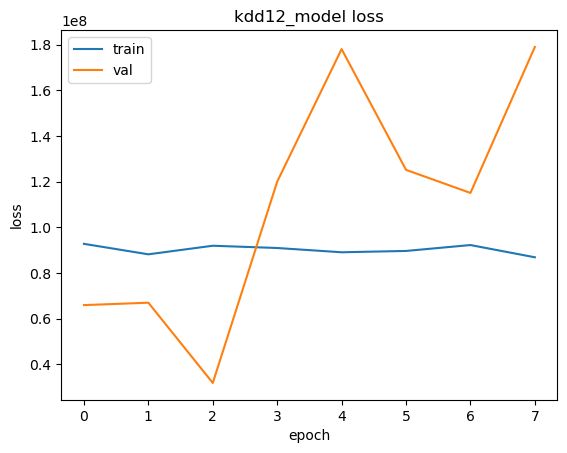

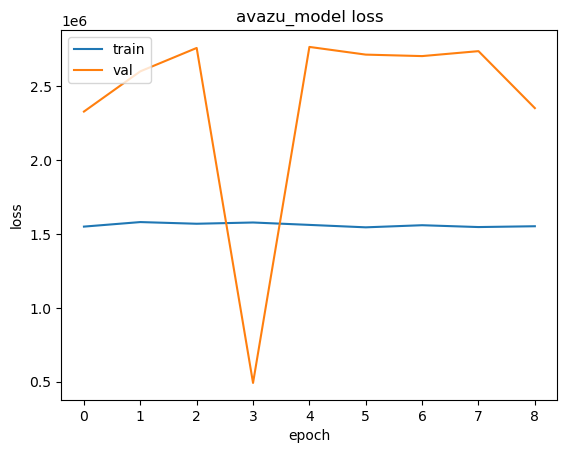

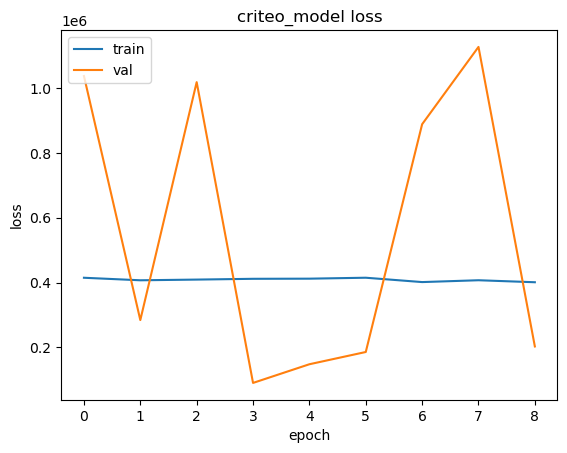

In [54]:
# Plot the training and validation losses for each epoch
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_lr.csv')
avazu_history = pd.read_csv('logs/avazu_lr.csv')
criteo_history = pd.read_csv('logs/criteo_lr.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Factorization Machine

Factorization Machines were first introduced in \citep{RefWorks:rendle2010factorization} as
a model class that ``combines the advantages of Support Vector Machines (SVM) with factorization models''.
The model is able to capture the second order feature interactions in the data, which is a key advantage over
Logistic Regression. The model is defined as follows:

$$
\hat{y}(\mathbf{x}) = w_0 + \sum_{i=1}^{n} w_i x_i + \sum_{i=1}^{n} \sum_{j=i+1}^{n} \langle \mathbf{v}_i, \mathbf{v}_j \rangle x_i x_j
$$

where $w_0$ is the bias term, $w_i$ are the weights for the $i$-th feature, $\mathbf{v}_i$ are the latent vectors for the $i$-th feature.
Rendel (2020) shows that the learned biases and weights of the FM model can be
computed in linear time, ``and can be learned efficiently by gradient descent methods'', such as Stochastic Gradient Descent (SGD).

In the code below, I replicate the FM model by first creating a custom `tf.keras.layers.Layer` class that carries out the
forward calculation above. The trainable weights of the layer are then optimized using Stochastic Gradient Descent with 
`learning_rate=0.01`.

In [62]:
# Define custom FactorizationMachine layer
class FactorizationMachine(tf.keras.layers.Layer):
    def __init__(self, k, name="FM_layer"):
        super(FactorizationMachine, self).__init__(name=name)
        self.k = k

    def build(self, input_shape):
        self.w0 = self.add_weight("bias", shape=(1,), initializer=tf.keras.initializers.GlorotNormal())
        self.W = self.add_weight("weights", shape=(input_shape[-1],), initializer=tf.keras.initializers.GlorotNormal())
        self.V = self.add_weight("interaction_factors", shape=(self.k, input_shape[-1]), initializer=tf.keras.initializers.GlorotNormal())

    def call(self, inputs):
        linear_terms = tf.add(
            self.w0,
            tf.reduce_sum(
                tf.multiply(self.W, inputs),
                axis=1,
                keepdims=True
            )
        )
        interaction_terms = tf.multiply(
            0.5,
            tf.reduce_sum(
                tf.math.subtract(
                    tf.pow(tf.matmul(inputs, tf.transpose(self.V)), 2),
                    tf.matmul(tf.pow(inputs, 2), tf.transpose(tf.pow(self.V, 2)))
                ),
                axis=1, 
                keepdims=True
            )
        )
        return tf.add(linear_terms,interaction_terms)
        
    # Have to overwite the get_config method to save the model
    def get_config(self):
        config = super().get_config().copy()
        config.update({'k':self.k})
        return config

In [63]:
# Calculate the input shapes for each of the datasets
kdd12_ohe_shape = (len(kdd12_categorical_columns)*50 + len(kdd12_numerical_columns),)
avazu_ohe_shape = (len(avazu_categorical_columns)*50 + len(avazu_numerical_columns),)
criteo_ohe_shape = (len(criteo_categorical_columns)*50 + len(criteo_numerical_columns),)

In [64]:
# Create sequential Factorization Machine Models
kdd12_fm_model = Sequential([
    Input(shape=kdd12_ohe_shape),
    FactorizationMachine(5),
    Activation('sigmoid')
])
avazu_fm_model = Sequential([
    Input(shape=avazu_ohe_shape),
    FactorizationMachine(5),
    Activation('sigmoid')
])
criteo_fm_model = Sequential([
    Input(shape=criteo_ohe_shape),
    FactorizationMachine(5),
    Activation('sigmoid')
])

In [65]:
# Define the CSVLogger callbacks
kdd12_fm_csvLogger = CSVLogger('logs/kdd12_fm.csv')
avazu_fm_csvLogger = CSVLogger('logs/avazu_fm.csv')
criteo_fm_csvLogger = CSVLogger('logs/criteo_fm.csv')

In [66]:
# Define the model saving checkpoints
kdd12_fm_modelCheckpoint = ModelCheckpoint(
    'models/fm/kdd12/kdd12_fm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_fm_modelCheckpoint = ModelCheckpoint(
    'models/fm/avazu/avazu_fm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_fm_modelCheckpoint = ModelCheckpoint(
    'models/fm/criteo/criteo_fm.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [67]:
# Compile the models
sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)


kdd12_fm_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
avazu_fm_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
criteo_fm_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)

In [68]:
# Fit the models
kdd12_fm_model.fit(
    kdd12_train_ohe,
    validation_data = kdd12_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[kdd12_fm_csvLogger, kdd12_fm_modelCheckpoint, earlystopping]
)
avazu_fm_model.fit(
    avazu_train_ohe,
    validation_data = avazu_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[avazu_fm_csvLogger, avazu_fm_modelCheckpoint, earlystopping]
)
criteo_fm_model.fit(
    criteo_train_ohe,
    validation_data = criteo_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[criteo_fm_csvLogger, criteo_fm_modelCheckpoint, earlystopping]
)

Epoch 1/15
    615/Unknown - 18s 28ms/step - loss: 0.2609 - binary_crossentropy: 0.2609 - binary_accuracy: 0.9551 - precision: 0.6667 - recall: 2.2658e-04 - auc: 0.5217

2024-08-07 10:10:56.780272: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5413920382215297349
2024-08-07 10:10:56.780338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6218650648287247715
2024-08-07 10:10:56.780352: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 894144068559659924
2024-08-07 10:10:56.780389: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15290879069443237686


615/615 [==============================] - 23s 36ms/step - loss: 0.2609 - binary_crossentropy: 0.2609 - binary_accuracy: 0.9551 - precision: 0.6667 - recall: 2.2658e-04 - auc: 0.5217 - val_loss: 0.1924 - val_binary_crossentropy: 0.1924 - val_binary_accuracy: 0.9553 - val_precision: 1.0000 - val_recall: 5.6850e-04 - val_auc: 0.5778
Epoch 2/15
  1/615 [..............................] - ETA: 21s - loss: 0.2431 - binary_crossentropy: 0.2431 - binary_accuracy: 0.9531 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6790

2024-08-07 10:11:01.432114: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7271649440623032395
2024-08-07 10:11:01.432169: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14073422632403482401
2024-08-07 10:11:01.432195: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10533768720214818812


615/615 [==============================] - 22s 36ms/step - loss: 0.2114 - binary_crossentropy: 0.2114 - binary_accuracy: 0.9551 - precision: 0.5000 - recall: 1.4148e-04 - auc: 0.5764 - val_loss: 0.1584 - val_binary_crossentropy: 0.1584 - val_binary_accuracy: 0.9553 - val_precision: 1.0000 - val_recall: 5.6850e-04 - val_auc: 0.5939
Epoch 3/15
615/615 [==============================] - 22s 36ms/step - loss: 0.1995 - binary_crossentropy: 0.1995 - binary_accuracy: 0.9551 - precision: 0.5000 - recall: 1.4148e-04 - auc: 0.5940 - val_loss: 0.1373 - val_binary_crossentropy: 0.1373 - val_binary_accuracy: 0.9553 - val_precision: 1.0000 - val_recall: 5.6850e-04 - val_auc: 0.6019
Epoch 4/15
615/615 [==============================] - 22s 36ms/step - loss: 0.1949 - binary_crossentropy: 0.1949 - binary_accuracy: 0.9551 - precision: 0.6667 - recall: 2.8297e-04 - auc: 0.6023 - val_loss: 0.1196 - val_binary_crossentropy: 0.1196 - val_binary_accuracy: 0.9553 - val_precision: 1.0000 - val_recall: 5.6850e-

2024-08-07 10:16:34.181241: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5413920382215297349
2024-08-07 10:16:34.181316: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 894144068559659924
2024-08-07 10:16:34.181332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2270599650508870994
2024-08-07 10:16:34.181365: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15290879069443237686


615/615 [==============================] - 30s 48ms/step - loss: 0.4469 - binary_crossentropy: 0.4469 - binary_accuracy: 0.8307 - precision: 1.0000 - recall: 7.0395e-05 - auc: 0.6576 - val_loss: 0.4357 - val_binary_crossentropy: 0.4357 - val_binary_accuracy: 0.8330 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6342
Epoch 2/15


2024-08-07 10:16:40.478670: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7271649440623032395
2024-08-07 10:16:40.478730: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14073422632403482401
2024-08-07 10:16:40.478757: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10533768720214818812


615/615 [==============================] - 29s 47ms/step - loss: 0.4352 - binary_crossentropy: 0.4352 - binary_accuracy: 0.8307 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6483 - val_loss: 0.4312 - val_binary_crossentropy: 0.4312 - val_binary_accuracy: 0.8330 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6461
Epoch 3/15
615/615 [==============================] - 29s 47ms/step - loss: 0.4316 - binary_crossentropy: 0.4316 - binary_accuracy: 0.8307 - precision: 0.5000 - recall: 7.5041e-05 - auc: 0.6589 - val_loss: 0.4287 - val_binary_crossentropy: 0.4287 - val_binary_accuracy: 0.8330 - val_precision: 0.6667 - val_recall: 3.0423e-04 - val_auc: 0.6552
Epoch 4/15
615/615 [==============================] - 29s 47ms/step - loss: 0.4294 - binary_crossentropy: 0.4294 - binary_accuracy: 0.8306 - precision: 0.3810 - recall: 0.0015 - auc: 0.6666 - val_loss: 0.4268 - val_binary_crossentropy: 0.4268 - val_binary_accuracy: 0.8328 - val_precision: 0.3846 - val_recall: 0.00

2024-08-07 10:25:29.342610: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5413920382215297349
2024-08-07 10:25:29.342674: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 894144068559659924
2024-08-07 10:25:29.342687: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3187023270766357300
2024-08-07 10:25:29.342698: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16466181589635642840
2024-08-07 10:25:29.342727: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15290879069443237686


615/615 [==============================] - 173s 281ms/step - loss: 0.6188 - binary_crossentropy: 0.6188 - binary_accuracy: 0.6599 - precision: 0.3656 - recall: 0.0964 - auc: 0.6396 - val_loss: 0.5912 - val_binary_crossentropy: 0.5912 - val_binary_accuracy: 0.6915 - val_precision: 0.6158 - val_recall: 0.0743 - val_auc: 0.6645


2024-08-07 10:26:24.033641: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7271649440623032395
2024-08-07 10:26:24.033705: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14073422632403482401
2024-08-07 10:26:24.033738: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10533768720214818812


Epoch 2/15
615/615 [==============================] - 172s 280ms/step - loss: 0.5829 - binary_crossentropy: 0.5829 - binary_accuracy: 0.6983 - precision: 0.6163 - recall: 0.1095 - auc: 0.6776 - val_loss: 0.5810 - val_binary_crossentropy: 0.5810 - val_binary_accuracy: 0.7017 - val_precision: 0.6330 - val_recall: 0.1429 - val_auc: 0.6818
Epoch 3/15
615/615 [==============================] - 172s 279ms/step - loss: 0.5755 - binary_crossentropy: 0.5755 - binary_accuracy: 0.7055 - precision: 0.6251 - recall: 0.1604 - auc: 0.6894 - val_loss: 0.5764 - val_binary_crossentropy: 0.5764 - val_binary_accuracy: 0.7060 - val_precision: 0.6293 - val_recall: 0.1789 - val_auc: 0.6893
Epoch 4/15
615/615 [==============================] - 171s 279ms/step - loss: 0.5715 - binary_crossentropy: 0.5715 - binary_accuracy: 0.7093 - precision: 0.6259 - recall: 0.1891 - auc: 0.6956 - val_loss: 0.5736 - val_binary_crossentropy: 0.5736 - val_binary_accuracy: 0.7081 - val_precision: 0.6266 - val_recall: 0.1980 - va

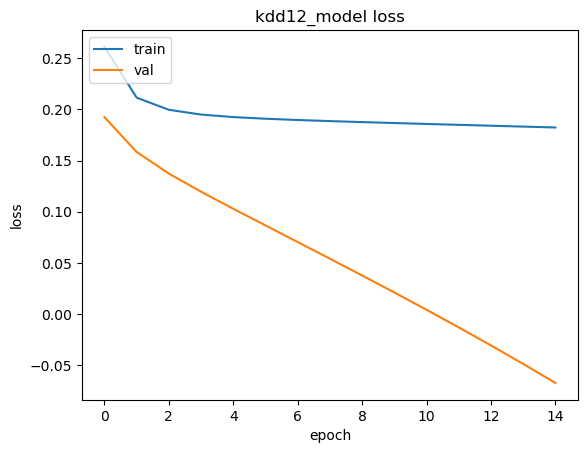

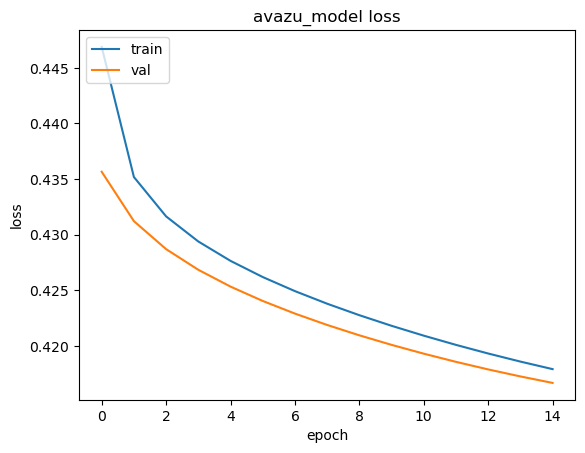

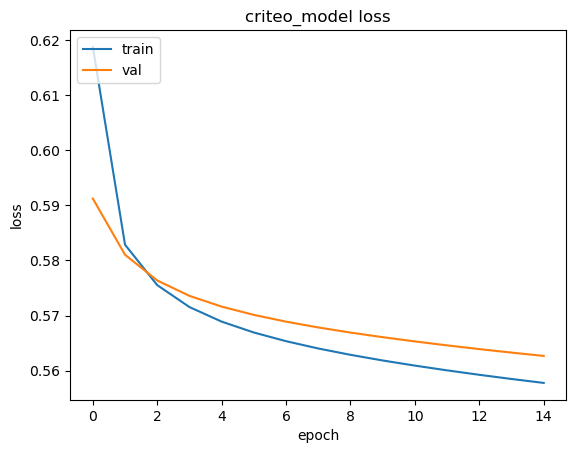

In [69]:
# Plot the training and validation losses for each epoch
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_fm.csv')
avazu_history = pd.read_csv('logs/avazu_fm.csv')
criteo_history = pd.read_csv('logs/criteo_fm.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Deep Models

As explained above, I will explore a number of deep learning models. I selected five popular models on the basis of the following criteria

- Competitive predition accuracy in the KDD12, Criteo and Avazu datasets as published on [PapersWithCode](https://paperswithcode.com/)
- Ideally, I was looking for a representitive set of models for each model type as discussed in (Zhang et. al. 2021). Therefore I was looking for models that employed Product Interaction Opetators, Attention Operators and Factorization Machines as a basis.
- The code for the model has to be accessible and intuitive to use.

On the basis of the above critea, I have chosen the following models to explore:

- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Automatic Feature Interaction (AutoInt)

In the section below, I briefly introduce each of the models, and evaluate against the benchmark datasets loaded and preprocessed above.

### Factorization-Machine Supported Neural Networks

The first Deep Learning model that we will consider is the Factorization Supported
Neural Network (FNN) model proposed by Zhang et. al. (2016). The model works by first training a Factorization Machine
model on the sparse-encoded categorical input features. It then uses the latent vectors learned by the FM model (see $\mathbf{v}_i$ in the equation above)
as inputs to a Neural Network, as shown in the figure below. In doing so, the FNN model is effectively using the FM latent factors to initialize the embedding layer of the Neural Network.
The DNN is then able to learn the higher order feature interactions in the data, which the FM model is unable to capture.

![FNN](figures/fnn.png)

In [70]:
# Compile the models
kdd12_fnn_model = FNN(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005
    )
kdd12_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

avazu_fnn_model = FNN(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005
    )
avazu_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_fnn_model = FNN(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005
    )
criteo_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

In [71]:
# Define the CSVLogger callbacks
kdd12_fnn_csvLogger = CSVLogger('logs/kdd12_fnn.csv')
avazu_fnn_csvLogger = CSVLogger('logs/avazu_fnn.csv')
criteo_fnn_csvLogger = CSVLogger('logs/criteo_fnn.csv')

In [72]:
# Define the model saving checkpoints
kdd12_fnn_modelCheckpoint = ModelCheckpoint(
    'models/fnn/kdd12/kdd12_fnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_fnn_modelCheckpoint = ModelCheckpoint(
    'models/fnn/avazu/avazu_fnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_fnn_modelCheckpoint = ModelCheckpoint(
    'models/fnn/criteo/criteo_fnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [73]:
# Fit the models
kdd12_fnn_history = kdd12_fnn_model.fit(kdd12_train_model_input, validation_data=kdd12_val_model_input, batch_size=256, epochs=15, callbacks=[kdd12_fnn_csvLogger,kdd12_fnn_modelCheckpoint,earlystopping])
avazu_fnn_history = avazu_fnn_model.fit(avazu_train_model_input, validation_data=avazu_val_model_input, batch_size=256, epochs=15, callbacks=[avazu_fnn_csvLogger,avazu_fnn_modelCheckpoint,earlystopping])
criteo_fnn_history = criteo_fnn_model.fit(criteo_train_model_input, validation_data=criteo_val_model_input, batch_size=256, epochs=15, callbacks=[criteo_fnn_csvLogger,criteo_fnn_modelCheckpoint,earlystopping])

Epoch 1/15


2024-08-07 11:06:37.199655: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


    615/Unknown - 24s 30ms/step - loss: 0.4386 - binary_crossentropy: 0.2088 - binary_accuracy: 0.9524 - precision: 0.5860 - recall: 0.1659 - auc: 0.7750

2024-08-07 11:06:57.952312: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7635484905759896469
2024-08-07 11:06:57.952364: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11235231564714354254
2024-08-07 11:07:03.027940: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16221806829484970910


615/615 [==============================] - 30s 40ms/step - loss: 0.4386 - binary_crossentropy: 0.2088 - binary_accuracy: 0.9524 - precision: 0.5860 - recall: 0.1659 - auc: 0.7750 - val_loss: 0.1909 - val_binary_crossentropy: 0.1766 - val_binary_accuracy: 0.9553 - val_precision: 1.0000 - val_recall: 5.6850e-04 - val_auc: 0.6114
Epoch 2/15
615/615 [==============================] - 24s 39ms/step - loss: 0.2079 - binary_crossentropy: 0.1978 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5602 - val_loss: 0.1703 - val_binary_crossentropy: 0.1625 - val_binary_accuracy: 0.9553 - val_precision: 1.0000 - val_recall: 5.6850e-04 - val_auc: 0.6214
Epoch 3/15
615/615 [==============================] - 24s 39ms/step - loss: 0.2025 - binary_crossentropy: 0.1960 - binary_accuracy: 0.9551 - precision: 0.5000 - recall: 1.4148e-04 - auc: 0.5746 - val_loss: 0.1589 - val_binary_crossentropy: 0.1537 - val_binary_accuracy: 0.9553 - val_precision: 1.0000 - val_recall: 5.6850e-

2024-08-07 11:12:25.054566: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1174391456555862082
2024-08-07 11:12:25.054638: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13200322621768278421
2024-08-07 11:12:25.054665: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3895767743328801545
2024-08-07 11:12:25.054678: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8751905479859911733
2024-08-07 11:12:25.054690: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17577201869432694167


615/615 [==============================] - 39s 50ms/step - loss: 0.7044 - binary_crossentropy: 0.4569 - binary_accuracy: 0.8226 - precision: 0.2498 - recall: 0.0223 - auc: 0.6585 - val_loss: 0.4598 - val_binary_crossentropy: 0.4252 - val_binary_accuracy: 0.8330 - val_precision: 0.6667 - val_recall: 6.0846e-04 - val_auc: 0.6690
Epoch 2/15
615/615 [==============================] - 30s 48ms/step - loss: 0.4643 - binary_crossentropy: 0.4346 - binary_accuracy: 0.8295 - precision: 0.4197 - recall: 0.0180 - auc: 0.6498 - val_loss: 0.4482 - val_binary_crossentropy: 0.4229 - val_binary_accuracy: 0.8330 - val_precision: 0.4286 - val_recall: 4.5634e-04 - val_auc: 0.6784
Epoch 3/15
615/615 [==============================] - 30s 48ms/step - loss: 0.4520 - binary_crossentropy: 0.4302 - binary_accuracy: 0.8301 - precision: 0.4394 - recall: 0.0137 - auc: 0.6627 - val_loss: 0.4402 - val_binary_crossentropy: 0.4220 - val_binary_accuracy: 0.8330 - val_precision: 0.5556 - val_recall: 7.6057e-04 - val_auc

2024-08-07 11:22:34.034835: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12181468719034840053
2024-08-07 11:22:34.034885: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9541954332669778975
2024-08-07 11:22:34.034899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8751905479859911733
2024-08-07 11:22:34.034912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16242685403762990590


615/615 [==============================] - 184s 283ms/step - loss: 0.8447 - binary_crossentropy: 0.5778 - binary_accuracy: 0.7034 - precision: 0.5824 - recall: 0.1786 - auc: 0.7005 - val_loss: 0.5876 - val_binary_crossentropy: 0.5663 - val_binary_accuracy: 0.7135 - val_precision: 0.6471 - val_recall: 0.2136 - val_auc: 0.7084
Epoch 2/15
615/615 [==============================] - 174s 283ms/step - loss: 0.5804 - binary_crossentropy: 0.5632 - binary_accuracy: 0.7143 - precision: 0.6388 - recall: 0.2115 - auc: 0.7110 - val_loss: 0.5801 - val_binary_crossentropy: 0.5658 - val_binary_accuracy: 0.7132 - val_precision: 0.6411 - val_recall: 0.2187 - val_auc: 0.7106
Epoch 3/15
615/615 [==============================] - 174s 282ms/step - loss: 0.5763 - binary_crossentropy: 0.5621 - binary_accuracy: 0.7147 - precision: 0.6448 - recall: 0.2075 - auc: 0.7143 - val_loss: 0.5791 - val_binary_crossentropy: 0.5648 - val_binary_accuracy: 0.7136 - val_precision: 0.6477 - val_recall: 0.2139 - val_auc: 0.71

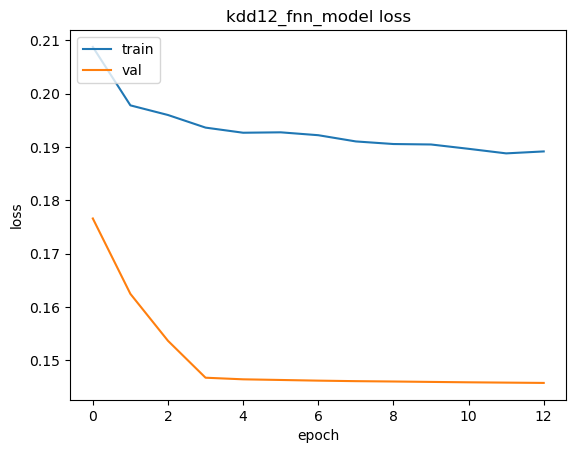

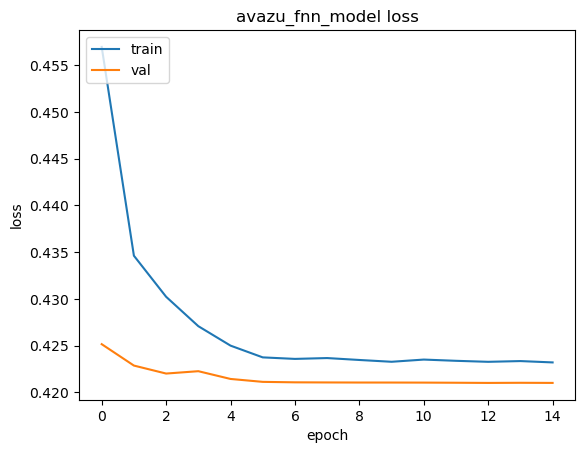

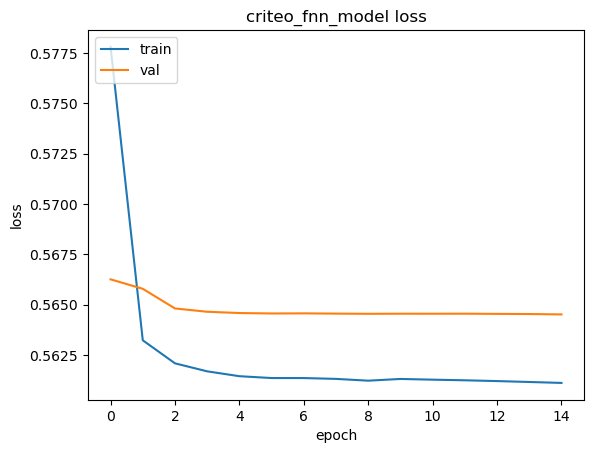

In [74]:
# Read in the history logs
kdd12_fnn_history = pd.read_csv('logs/kdd12_fnn.csv')
avazu_fnn_history = pd.read_csv('logs/avazu_fnn.csv')
criteo_fnn_history = pd.read_csv('logs/criteo_fnn.csv')

# Plot the training history
plt.plot(kdd12_fnn_history['binary_crossentropy'])
plt.plot(kdd12_fnn_history['val_binary_crossentropy'])
plt.title('kdd12_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_fnn_history['binary_crossentropy'])
plt.plot(avazu_fnn_history['val_binary_crossentropy'])
plt.title('avazu_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_fnn_history['binary_crossentropy'])
plt.plot(criteo_fnn_history['val_binary_crossentropy'])
plt.title('criteo_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [75]:
# Score the models
kdd12_fnn_score = kdd12_fnn_model.evaluate(kdd12_val_model_input, batch_size=256)
avazu_fnn_score = avazu_fnn_model.evaluate(avazu_val_model_input, batch_size=256)
criteo_fnn_score = criteo_fnn_model.evaluate(criteo_val_model_input, batch_size=256)

154/154 [==============================] - 6s 38ms/step - loss: 0.4287 - binary_crossentropy: 0.4210 - binary_accuracy: 0.8330 - precision: 0.5000 - recall: 1.5211e-04 - auc: 0.6865


2024-08-07 12:03:14.339274: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13200322621768278421
2024-08-07 12:03:14.339325: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3895767743328801545
2024-08-07 12:03:14.339335: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8751905479859911733


154/154 [==============================] - 55s 352ms/step - loss: 0.5789 - binary_crossentropy: 0.5645 - binary_accuracy: 0.7140 - precision: 0.6519 - recall: 0.2117 - auc: 0.7133


2024-08-07 12:04:08.956689: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16242685403762990590
2024-08-07 12:04:08.956749: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12181468719034840053
2024-08-07 12:04:08.956776: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9541954332669778975


### Product Based Neural Networks

The Product Based Neural Network (PNN) model
proposed by Qu et. al. (2016) is another Deep Learning
model that was developed around the same time as the FNN model. The key 
innovation of the PNN moel is the use of a pair-wisely connected Product Layer
after a field-wise connected embetting layer for the categorical features, as shown
in the figure below. The Product Layer is able to directly model inter-field feature
interaction by means of either an inner product or outer production operation, and then further
distill higher feature inturactions by passing the output of the Product Layer through fully
connected MLP layers.

![PNN](figures/pnn.png)

In [87]:
# Define the CSVLogger callbacks
kdd12_pnn_csvLogger = CSVLogger('logs/kdd12_pnn.csv')
avazu_pnn_csvLogger = CSVLogger('logs/avazu_pnn.csv')
criteo_pnn_csvLogger = CSVLogger('logs/criteo_pnn.csv')

In [88]:
# Define the model saving checkpoints
kdd12_pnn_modelCheckpoint = ModelCheckpoint(
    'models/pnn/kdd12/kdd12_pnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_pnn_modelCheckpoint = ModelCheckpoint(
    'models/pnn/avazu/avazu_pnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_pnn_modelCheckpoint = ModelCheckpoint(
    'models/pnn/criteo/criteo_pnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [89]:
# Compile the PNN models
kdd12_pnn_model = PNN(
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
kdd12_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

avazu_pnn_model = PNN(
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
avazu_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_pnn_model = PNN(
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
criteo_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

In [ ]:
# Fit the models

kdd12_pnn_history = kdd12_pnn_model.fit(
    kdd12_train_model_input, 
    validation_data=kdd12_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_pnn_csvLogger,kdd12_pnn_modelCheckpoint,earlystopping]
)
avazu_pnn_history = avazu_pnn_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_pnn_csvLogger,avazu_pnn_modelCheckpoint,earlystopping]
)
criteo_pnn_history = criteo_pnn_model.fit(
    criteo_train_model_input,
    validation_data=criteo_val_model_input,
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_pnn_csvLogger,criteo_pnn_modelCheckpoint,earlystopping]
)

Epoch 1/15
    615/Unknown - 21s 30ms/step - loss: 0.4426 - binary_crossentropy: 0.2072 - binary_accuracy: 0.9545 - precision: 0.5974 - recall: 0.1937 - auc: 0.7956

2024-08-07 13:33:45.429571: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17009935969445986446
2024-08-07 13:33:50.359366: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17197407772471931008
2024-08-07 13:33:50.359422: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16387521651223331232
2024-08-07 13:33:50.359433: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4037773748042169270
2024-08-07 13:33:50.359442: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1547863190157827994


615/615 [==============================] - 26s 39ms/step - loss: 0.4426 - binary_crossentropy: 0.2072 - binary_accuracy: 0.9545 - precision: 0.5974 - recall: 0.1937 - auc: 0.7956 - val_loss: 0.2057 - val_binary_crossentropy: 0.1977 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5888
Epoch 2/15
615/615 [==============================] - 23s 38ms/step - loss: 0.2063 - binary_crossentropy: 0.2004 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5251 - val_loss: 0.2017 - val_binary_crossentropy: 0.1973 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5880
Epoch 3/15
615/615 [==============================] - 23s 37ms/step - loss: 0.2044 - binary_crossentropy: 0.2010 - binary_accuracy: 0.9551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5114 - val_loss: 0.2030 - val_binary_crossentropy: 0.2005 - val_binary_accuracy: 0.9553 - val_precision: 0.0000e+00 - val_

2024-08-07 13:36:37.125191: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18021640543037281040


615/615 [==============================] - 34s 49ms/step - loss: 0.6831 - binary_crossentropy: 0.4622 - binary_accuracy: 0.8299 - precision: 0.2019 - recall: 0.0015 - auc: 0.5836 - val_loss: 0.4525 - val_binary_crossentropy: 0.4515 - val_binary_accuracy: 0.8330 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/15
615/615 [==============================] - 29s 48ms/step - loss: 0.4580 - binary_crossentropy: 0.4573 - binary_accuracy: 0.8307 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4999 - val_loss: 0.4517 - val_binary_crossentropy: 0.4512 - val_binary_accuracy: 0.8330 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/15
615/615 [==============================] - 30s 48ms/step - loss: 0.4574 - binary_crossentropy: 0.4570 - binary_accuracy: 0.8307 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4999 - val_loss: 0.4514 - val_binary_crossentropy: 0.4511 - val_binary_accuracy: 0.8330 - val_precision: 0.0000e+00 - val_

2024-08-07 13:45:08.339380: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15970707317591911487
2024-08-07 13:45:08.339431: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7521688166734396553
2024-08-07 13:45:08.339442: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9248025684087996245
2024-08-07 13:45:08.339452: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14362183102785140736
2024-08-07 13:45:08.339461: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4757550019900514708
2024-08-07 13:45:08.339470: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13193857372129920320


615/615 [==============================] - 178s 281ms/step - loss: 0.8423 - binary_crossentropy: 0.5938 - binary_accuracy: 0.6852 - precision: 0.4967 - recall: 0.0215 - auc: 0.6625 - val_loss: 0.6015 - val_binary_crossentropy: 0.5867 - val_binary_accuracy: 0.6869 - val_precision: 0.6751 - val_recall: 0.0258 - val_auc: 0.6787
Epoch 2/15
615/615 [==============================] - 174s 283ms/step - loss: 0.6019 - binary_crossentropy: 0.5829 - binary_accuracy: 0.6958 - precision: 0.5800 - recall: 0.1204 - auc: 0.6754 - val_loss: 0.5983 - val_binary_crossentropy: 0.5777 - val_binary_accuracy: 0.7068 - val_precision: 0.6717 - val_recall: 0.1486 - val_auc: 0.6968
Epoch 3/15
615/615 [==============================] - 172s 280ms/step - loss: 0.5938 - binary_crossentropy: 0.5700 - binary_accuracy: 0.7112 - precision: 0.5979 - recall: 0.2513 - auc: 0.6967 - val_loss: 0.5913 - val_binary_crossentropy: 0.5670 - val_binary_accuracy: 0.7221 - val_precision: 0.6323 - val_recall: 0.2967 - val_auc: 0.71

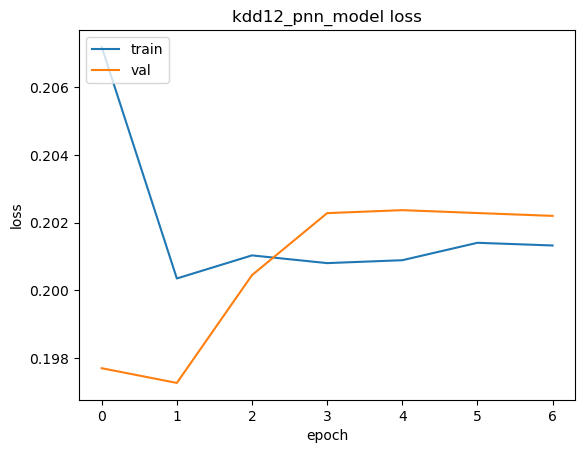

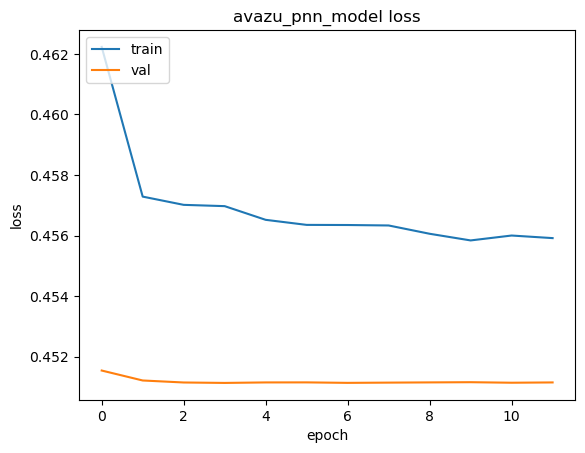

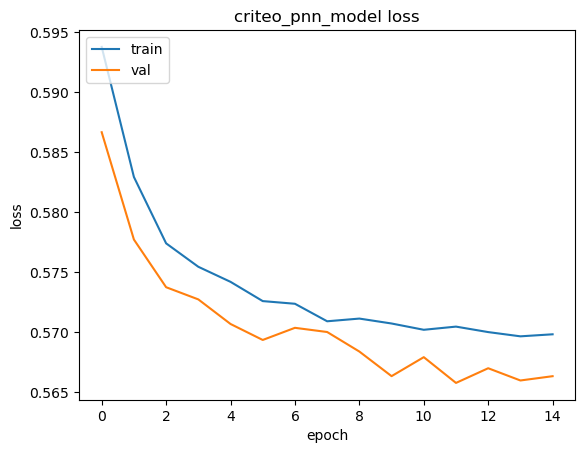

In [ ]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_pnn.csv')
avazu_history = pd.read_csv('logs/avazu_pnn.csv')
criteo_history = pd.read_csv('logs/criteo_pnn.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Wide and Deep

The Wide \& Deep Learning (WDL) model proposed by Cheng et. al. (2016) introduces the concept
of dual-tower model architecture (Zhang et. al. 2021). While both the FNN and the PNN models
generally tend to be constructed as a single fully connected DNN model, the Wide \& Deep model
consists of a wide component, consisting of a three layer Deep Neural Network that takes the concatinated
embedding vectors of the categorical features as input, and a deep component, consisting of a cross product
transformation of selected sparse categorical features. The logits from the wide and deep components are added
together to produce the final prediction. The architecture of the WDL model is shown in the figure below.

![WDL](figures/wdl.png)

The purpose behind the Dual-Tower architecture is to counteract the tendancy of the fully connected
single tower DNN models to lose the ability to capture low-order feature interactions (Zhang et. al. 2021).
The Wide component is able to capture the low-order feature interactions, while the Deep component is able to capture
the higher order feature interactions.

In [96]:
# Compile the WDL models
kdd12_wdl_model = WDL(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
kdd12_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

avazu_wdl_model = WDL(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
avazu_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_wdl_model = WDL(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
criteo_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

In [97]:
# Define the CSVLogger callbacks
kdd12_wdl_csvLogger = CSVLogger('logs/kdd12_wdl.csv')
avazu_wdl_csvLogger = CSVLogger('logs/avazu_wdl.csv')
criteo_wdl_csvLogger = CSVLogger('logs/criteo_wdl.csv')

In [101]:
# Define the model saving checkpoints
kdd12_wdl_modelCheckpoint = ModelCheckpoint(
    'models/wdl/kdd12/kdd12_wdl.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_wdl_modelCheckpoint = ModelCheckpoint(
    'models/wdl/avazu/avazu_wdl.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_wdl_modelCheckpoint = ModelCheckpoint(
    'models/wdl/criteo/criteo_wdl.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [102]:
# Fit the Wide and Deep models
'''
kdd12_wdl_history = kdd12_wdl_model.fit(
    kdd12_train_model_input, 
    validation_data=kdd12_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[kdd12_wdl_csvLogger,kdd12_wdl_modelCheckpoint,earlystopping]
)
avazu_wdl_history = avazu_wdl_model.fit(
    avazu_train_model_input, 
    validation_data=avazu_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_wdl_csvLogger,avazu_wdl_modelCheckpoint,earlystopping]

'''
criteo_wdl_history = criteo_wdl_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_wdl_csvLogger, criteo_wdl_modelCheckpoint,earlystopping]
)

Epoch 1/15
    615/Unknown - 125s 191ms/step - loss: 0.9162 - binary_crossentropy: 0.5964 - binary_accuracy: 0.6965 - precision: 0.5472 - recall: 0.1814 - auc: 0.6835

2024-08-07 15:04:00.456936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5997970489963459469
2024-08-07 15:04:00.456999: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 68783035531093603
2024-08-07 15:04:00.457011: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2610202641549371720
2024-08-07 15:04:55.335731: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13494594554781725273
2024-08-07 15:04:55.335785: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2460689578167746944


615/615 [==============================] - 180s 281ms/step - loss: 0.9162 - binary_crossentropy: 0.5964 - binary_accuracy: 0.6965 - precision: 0.5472 - recall: 0.1814 - auc: 0.6835 - val_loss: 0.6012 - val_binary_crossentropy: 0.5643 - val_binary_accuracy: 0.7175 - val_precision: 0.6442 - val_recall: 0.2453 - val_auc: 0.7135
Epoch 2/15
615/615 [==============================] - 176s 286ms/step - loss: 0.5932 - binary_crossentropy: 0.5640 - binary_accuracy: 0.7138 - precision: 0.6233 - recall: 0.2286 - auc: 0.7093 - val_loss: 0.5873 - val_binary_crossentropy: 0.5619 - val_binary_accuracy: 0.7161 - val_precision: 0.6648 - val_recall: 0.2125 - val_auc: 0.7167
Epoch 3/15
615/615 [==============================] - 172s 280ms/step - loss: 0.5828 - binary_crossentropy: 0.5604 - binary_accuracy: 0.7173 - precision: 0.6433 - recall: 0.2277 - auc: 0.7155 - val_loss: 0.5829 - val_binary_crossentropy: 0.5617 - val_binary_accuracy: 0.7166 - val_precision: 0.6702 - val_recall: 0.2107 - val_auc: 0.71

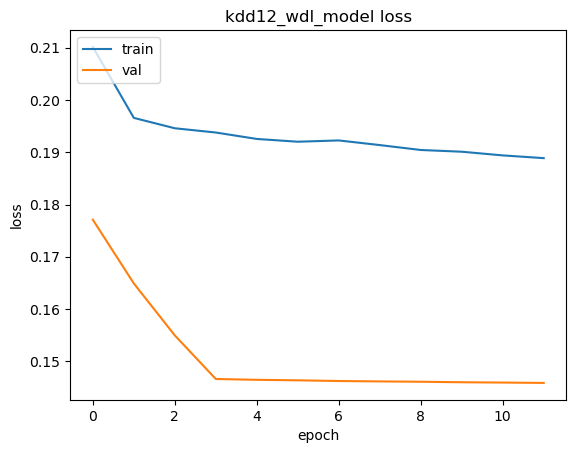

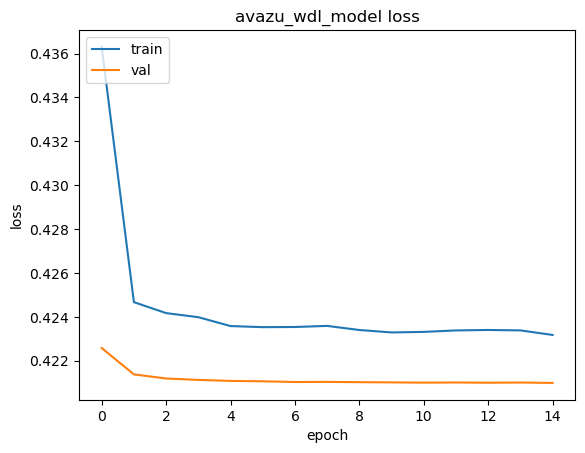

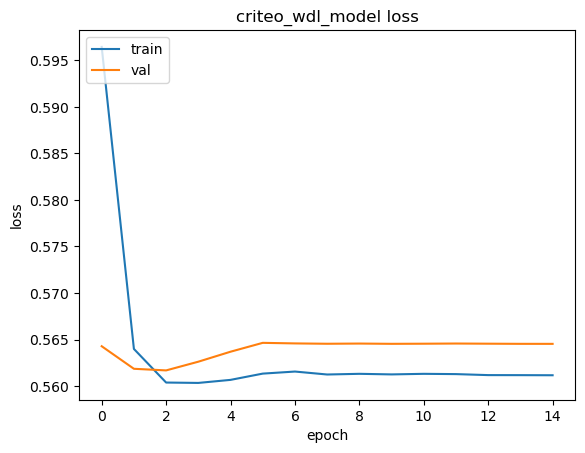

In [103]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_wdl.csv')
avazu_history = pd.read_csv('logs/avazu_wdl.csv')
criteo_history = pd.read_csv('logs/criteo_wdl.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### DeepFM

The DeepFM model proposed by Guo et. al. 2017 can be thought of as an
imporvement of the aforementioned FNN (Zhang et. al., 2016) and WDL (Cheng et. al., 2016) models.
Like the FNN model, the DeepFM model usilises the Factorization Machine model (Rendel, 2010)
to learn lower-order feature interactions. However, it also employs a dual-tower architecture
like the WDL model, with the Wide component being the FM model and the Deep component being a fully connected
DNN model. The DeepFM model is therefore able to avoid the limitations on capturing low-order
interactions that are inherent in the FNN model. In addition, due the the application of the FM to all
feature embeddings, the DeepFM model eliminates the need to choose which features 
to feed through the wide component, as is the case in the WDL model. The architecture of the DeepFM model is shown 
in the figure below.

![DFM](figures/dfm.png)

In [107]:
# Compile the DeepFM models

kdd12_dfm_model = DeepFM(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
)
kdd12_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

avazu_dfm_model = DeepFM(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
)
avazu_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_dfm_model = DeepFM(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
)
criteo_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

In [108]:
# Define the CSVLogger callbacks
kdd12_dfm_csvLogger = CSVLogger('logs/kdd12_dfm.csv')
avazu_dfm_csvLogger = CSVLogger('logs/avazu_dfm.csv')
criteo_dfm_csvLogger = CSVLogger('logs/criteo_dfm.csv')

In [109]:
# Define the model saving checkpoints
kdd12_dfm_modelCheckpoint = ModelCheckpoint(
    'models/dfm/kdd12/kdd12_dfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_dfm_modelCheckpoint = ModelCheckpoint(
    'models/dfm/avazu/avazu_dfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_dfm_modelCheckpoint = ModelCheckpoint(
    'models/dfm/criteo/criteo_dfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [110]:
# Fit the DeepFM models
'''
kdd12_dfm_history = kdd12_dfm_model.fit(
    kdd12_train_model_input, 
    validation_data = kdd12_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[kdd12_dfm_csvLogger,kdd12_dfm_modelCheckpoint,earlystopping]
)
'''
avazu_dfm_history = avazu_dfm_model.fit(
    avazu_train_model_input, 
    validation_data= avazu_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_dfm_csvLogger,avazu_dfm_modelCheckpoint,earlystopping]
)

criteo_dfm_history = criteo_dfm_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, epochs=15,
    callbacks=[criteo_dfm_csvLogger,criteo_dfm_modelCheckpoint,earlystopping]
)

Epoch 1/15
615/615 [==============================] - 39s 51ms/step - loss: 1.0221 - binary_crossentropy: 0.4731 - binary_accuracy: 0.8183 - precision: 0.4539 - recall: 0.0911 - auc: 0.6488 - val_loss: 0.4883 - val_binary_crossentropy: 0.4269 - val_binary_accuracy: 0.8332 - val_precision: 0.5087 - val_recall: 0.0312 - val_auc: 0.6692
Epoch 2/15
615/615 [==============================] - 30s 49ms/step - loss: 0.4611 - binary_crossentropy: 0.4221 - binary_accuracy: 0.8305 - precision: 0.4887 - recall: 0.0253 - auc: 0.6892 - val_loss: 0.4486 - val_binary_crossentropy: 0.4138 - val_binary_accuracy: 0.8338 - val_precision: 0.6220 - val_recall: 0.0120 - val_auc: 0.7030
Epoch 3/15
615/615 [==============================] - 30s 49ms/step - loss: 0.4501 - binary_crossentropy: 0.4164 - binary_accuracy: 0.8309 - precision: 0.5112 - recall: 0.0231 - auc: 0.7057 - val_loss: 0.4413 - val_binary_crossentropy: 0.4088 - val_binary_accuracy: 0.8346 - val_precision: 0.5614 - val_recall: 0.0438 - val_auc:

2024-08-07 15:58:41.735220: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2898017983812549167
2024-08-07 15:58:41.735278: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954856675897350885
2024-08-07 15:58:41.735303: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9541954332669778975
2024-08-07 15:58:41.735323: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3469744939332958618
2024-08-07 15:58:41.735357: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15301216800623741858
2024-08-07 15:58:41.735367: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17171082548911819982
2024-08-07 15:58:41.735377: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

615/615 [==============================] - 183s 282ms/step - loss: 1.2639 - binary_crossentropy: 0.6135 - binary_accuracy: 0.6916 - precision: 0.5213 - recall: 0.2238 - auc: 0.6809 - val_loss: 0.6687 - val_binary_crossentropy: 0.5641 - val_binary_accuracy: 0.7181 - val_precision: 0.6466 - val_recall: 0.2461 - val_auc: 0.7158
Epoch 2/15
615/615 [==============================] - 173s 282ms/step - loss: 0.6207 - binary_crossentropy: 0.5571 - binary_accuracy: 0.7218 - precision: 0.6286 - recall: 0.2829 - auc: 0.7181 - val_loss: 0.6048 - val_binary_crossentropy: 0.5546 - val_binary_accuracy: 0.7224 - val_precision: 0.6530 - val_recall: 0.2670 - val_auc: 0.7250
Epoch 3/15
615/615 [==============================] - 178s 289ms/step - loss: 0.6010 - binary_crossentropy: 0.5530 - binary_accuracy: 0.7228 - precision: 0.6299 - recall: 0.2887 - auc: 0.7240 - val_loss: 0.6077 - val_binary_crossentropy: 0.5598 - val_binary_accuracy: 0.7238 - val_precision: 0.6463 - val_recall: 0.2860 - val_auc: 0.71

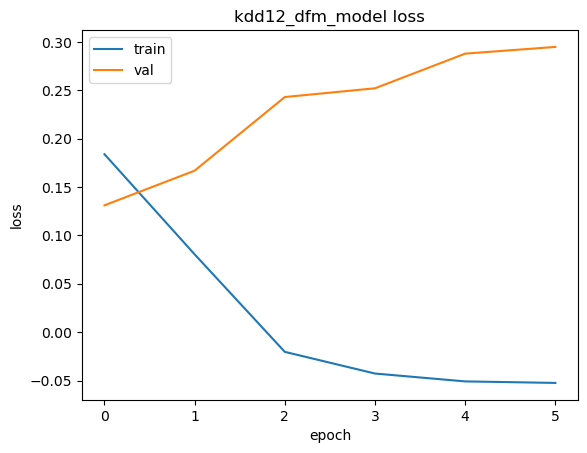

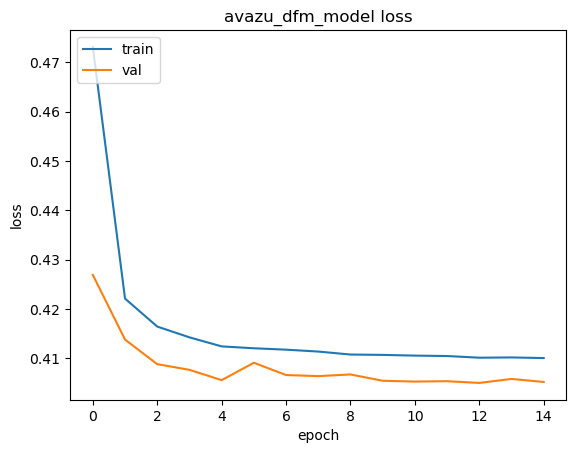

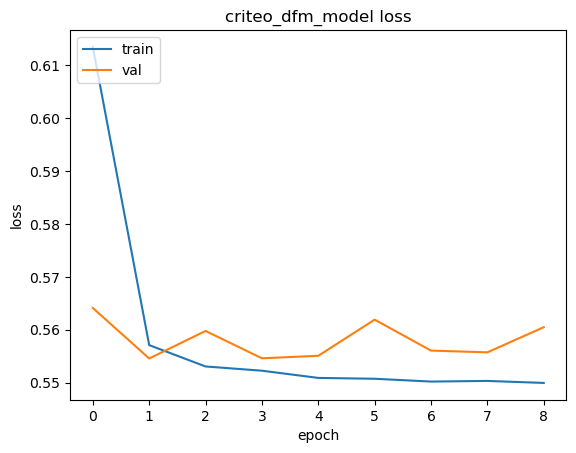

In [111]:
# Read in the history logs
kdd12_dfm_history = pd.read_csv('logs/kdd12_dfm.csv')
avazu_dfm_history = pd.read_csv('logs/avazu_dfm.csv')
criteo_dfm_history = pd.read_csv('logs/criteo_dfm.csv')

# Plot the training history
plt.plot(kdd12_dfm_history['binary_crossentropy'])
plt.plot(kdd12_dfm_history['val_binary_crossentropy'])
plt.title('kdd12_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_dfm_history['binary_crossentropy'])
plt.plot(avazu_dfm_history['val_binary_crossentropy'])
plt.title('avazu_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_dfm_history['binary_crossentropy'])
plt.plot(criteo_dfm_history['val_binary_crossentropy'])
plt.title('criteo_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Automatic Feature Interaction (AutoInt)

The Autotomatic Feature Interaction Learning (AutoInt) model proposed by
Song et. al. (2019) makes use of a multi-head self attention
network to model the important feature interactions in the data. The initial 
paper separates the model into three parts: an embedding layer, an interaction layer 
and an output layer. The embedding layer aims to project each sparse multi-value
categorical a and dense numerical feature into a lower dimensional space, as per the below:

$$
\mathbf{e_i} = \frac{1}{q} \mathbf{V_i x_i}
$$

where $\mathbf{V_i}$ is the embedding matrix for the $i$-th field, $x_i$ is a multi-hot vector, and $q$ 
is the number of non-zero values in $x_i$. The interaction layer employs the multi-head
mechanism to determine which higher order feature interaction are meaningful in the data. This not only
improves the efficiency of model traning, but it also improves the model's explainability. Lastly,
the output layer is a fully connected layer that takes in the concatinated output 
of the interaction layer, and applies the sigmoid activation function to produce the final prediction.
The architecture of the AutoInt model is shown in Figure below.

![AUTOINT](figures/autoint.png)

In [112]:
# Compile the AutoInt Models
kdd12_autoint_model = AutoInt(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
kdd12_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

avazu_autoint_model = AutoInt(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
avazu_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_autoint_model = AutoInt(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
criteo_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

In [113]:
# Define the AutoInt CSVLogger callbacks
kdd12_autoint_csvLogger = CSVLogger('logs/kdd12_autoint.csv')
avazu_autoint_csvLogger = CSVLogger('logs/avazu_autoint.csv')
criteo_autoint_csvLogger = CSVLogger('logs/criteo_autoint.csv')

In [114]:
# Define the model saving checkpoints
kdd12_autoint_modelCheckpoint = ModelCheckpoint(
    'models/autoint/kdd12/kdd12_autoint.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_autoint_modelCheckpoint = ModelCheckpoint(
    'models/autoint/avazu/avazu_autoint.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_autoint_modelCheckpoint = ModelCheckpoint(
    'models/autoint/criteo/criteo_autoint.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [115]:
# Fit the AutoInt models
'''
kdd12_autoint_model.fit(
    kdd12_train_model_input, 
    validation_data= kdd12_val_model_input, 
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_autoint_csvLogger, kdd12_autoint_modelCheckpoint,earlystopping]
)
'''
avazu_autoint_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[avazu_autoint_csvLogger, avazu_autoint_modelCheckpoint,earlystopping]
)
criteo_autoint_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_autoint_csvLogger,criteo_autoint_modelCheckpoint,earlystopping]
)

Epoch 1/15
    614/Unknown - 33s 39ms/step - loss: 0.8302 - binary_crossentropy: 0.4335 - binary_accuracy: 0.8243 - precision: 0.5310 - recall: 0.1218 - auc: 0.7047

2024-08-07 16:53:47.621063: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8800417385159226588
2024-08-07 16:53:47.621134: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13494594554781725273
2024-08-07 16:53:47.621154: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954856675897350885
2024-08-07 16:53:47.621164: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8892344697752712609


615/615 [==============================] - 40s 51ms/step - loss: 0.8296 - binary_crossentropy: 0.4335 - binary_accuracy: 0.8243 - precision: 0.5310 - recall: 0.1217 - auc: 0.7048 - val_loss: 0.4524 - val_binary_crossentropy: 0.4132 - val_binary_accuracy: 0.8339 - val_precision: 0.5311 - val_recall: 0.0493 - val_auc: 0.7069
Epoch 2/15
615/615 [==============================] - 31s 50ms/step - loss: 0.4415 - binary_crossentropy: 0.4089 - binary_accuracy: 0.8322 - precision: 0.5422 - recall: 0.0572 - auc: 0.7230 - val_loss: 0.4356 - val_binary_crossentropy: 0.4052 - val_binary_accuracy: 0.8354 - val_precision: 0.5716 - val_recall: 0.0570 - val_auc: 0.7222
Epoch 3/15
615/615 [==============================] - 31s 50ms/step - loss: 0.4379 - binary_crossentropy: 0.4067 - binary_accuracy: 0.8328 - precision: 0.5573 - recall: 0.0600 - auc: 0.7275 - val_loss: 0.4355 - val_binary_crossentropy: 0.4040 - val_binary_accuracy: 0.8354 - val_precision: 0.5716 - val_recall: 0.0577 - val_auc: 0.7251
Epo

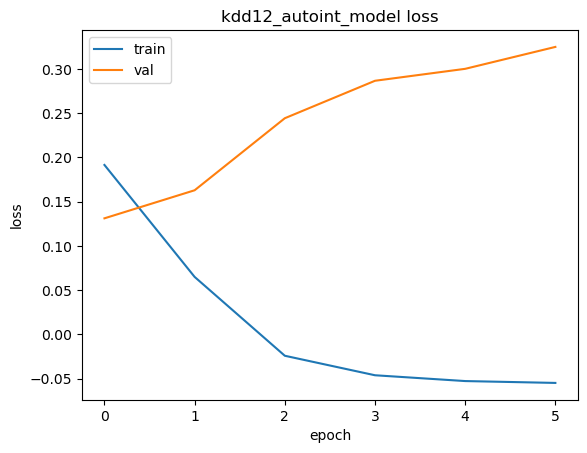

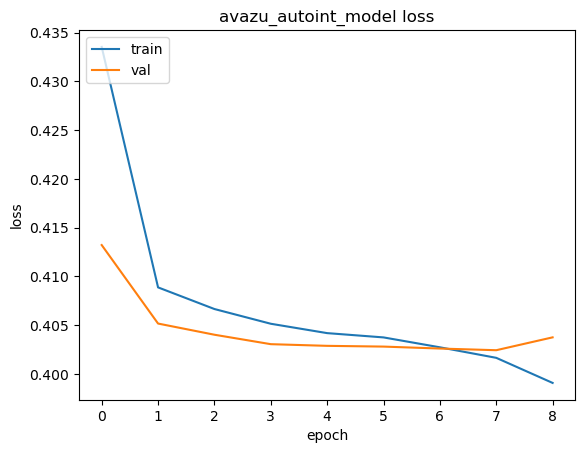

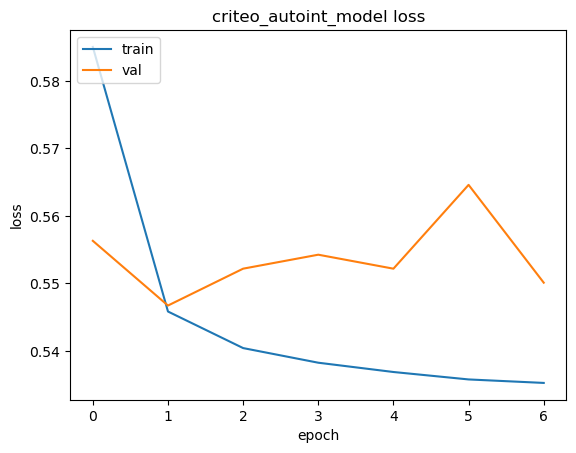

In [117]:
# Read in the history logs
kdd12_autoint_history = pd.read_csv('logs/kdd12_autoint.csv')
avazu_autoint_history = pd.read_csv('logs/avazu_autoint.csv')
criteo_autoint_history = pd.read_csv('logs/criteo_autoint.csv')

# Plot the training history
plt.plot(kdd12_autoint_history['binary_crossentropy'])
plt.plot(kdd12_autoint_history['val_binary_crossentropy'])
plt.title('kdd12_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_autoint_history['binary_crossentropy'])
plt.plot(avazu_autoint_history['val_binary_crossentropy'])
plt.title('avazu_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_autoint_history['binary_crossentropy'])
plt.plot(criteo_autoint_history['val_binary_crossentropy'])
plt.title('criteo_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Analysis of Results and Discussion

Below I construct and display a pandas dataframe of the best results in each of the logs in terms of validation loss. The accompanying validation metrics are also shown

In [118]:
# Construct pandas dataframe of the model scores for the kdd12 dataset
models = ['lr','fm','fnn','pnn','wdl','dfm','autoint']
datasets = ['kdd12','avazu','criteo']

for dataset in datasets:
    df = pd.DataFrame()
    for model in models:
        log_file = f'logs/{dataset}_{model}.csv'
        history = pd.read_csv(log_file)
        min_loss = history[history['val_loss']==history['val_loss'].min()]
        min_loss_val = min_loss.loc[:,['epoch','val_binary_crossentropy','val_binary_accuracy','val_precision','val_recall']]
        min_loss_val['model'] = model
        df = pd.concat([df,min_loss_val],axis=0)
    df = df.set_index('model')
    df.to_csv(f'logs/{dataset}_model_scores.csv')

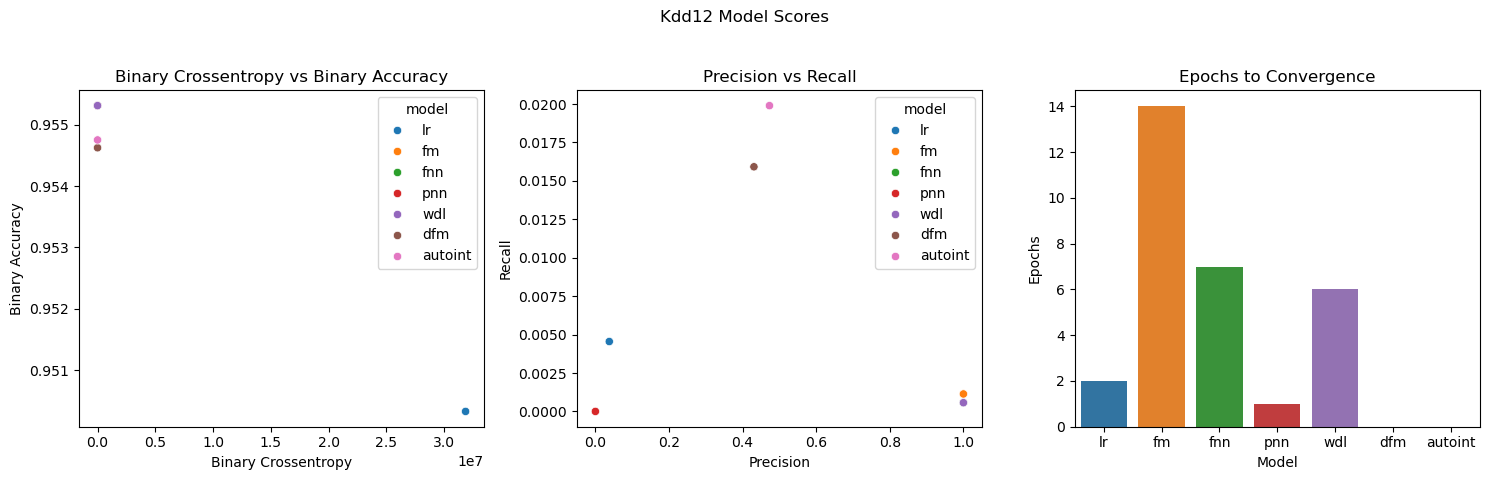

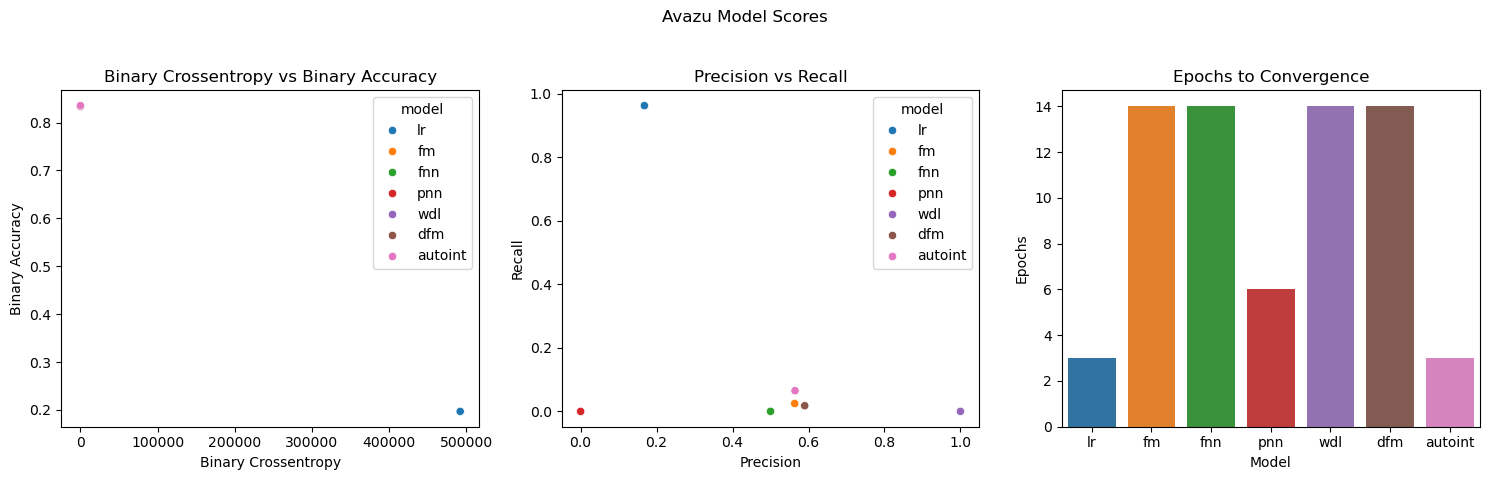

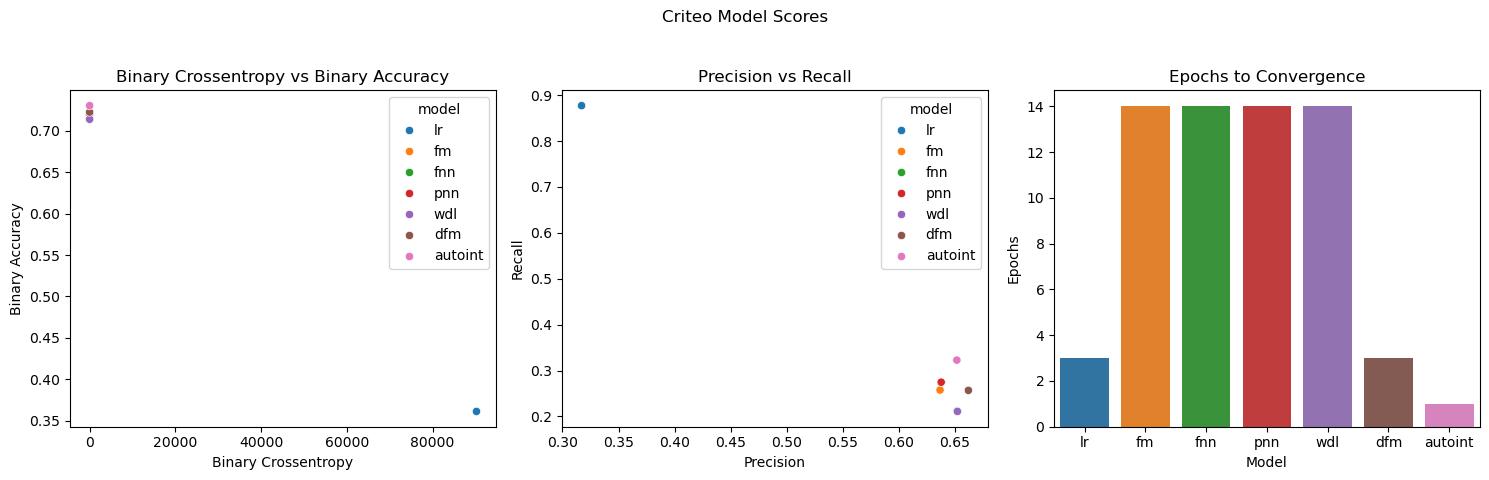

In [119]:
# Plot the the model scores by data set

for dataset in datasets:
    df = pd.read_csv(f'logs/{dataset}_model_scores.csv')
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{dataset.capitalize()} Model Scores')
    
    # Plot a scatter plot of binary crossentropy loss vs binary accuracy
    sns.scatterplot(ax=axs[0], data=df, x='val_binary_crossentropy', y='val_binary_accuracy', hue='model', palette='tab10')
    axs[0].set_title('Binary Crossentropy vs Binary Accuracy')
    axs[0].set_xlabel('Binary Crossentropy')
    axs[0].set_ylabel('Binary Accuracy')

    # Plot a scatter plot of Precision vs Recall
    sns.scatterplot(ax=axs[1], data=df, x='val_precision', y='val_recall', hue='model', palette='tab10')
    axs[1].set_title('Precision vs Recall')
    axs[1].set_xlabel('Precision')
    axs[1].set_ylabel('Recall')

    # Plot a bar chart of epoch number by model
    sns.barplot(ax=axs[2], data=df, x='model', y='epoch', palette='tab10')
    axs[2].set_title('Epochs to Convergence')
    axs[2].set_xlabel('Model')
    axs[2].set_ylabel('Epochs')

    # Arrange the subplots so that the axis labels do not overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the figure in the figures folder and show the plot
    plt.savefig(f'figures/{dataset}_model_scores.png')
    plt.show()

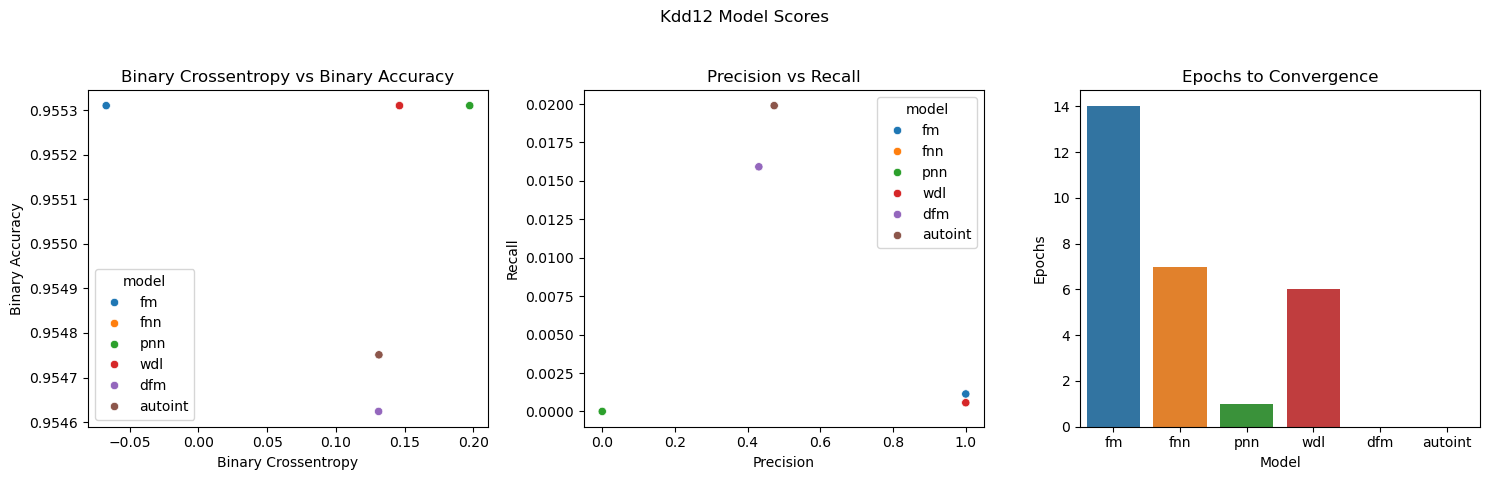

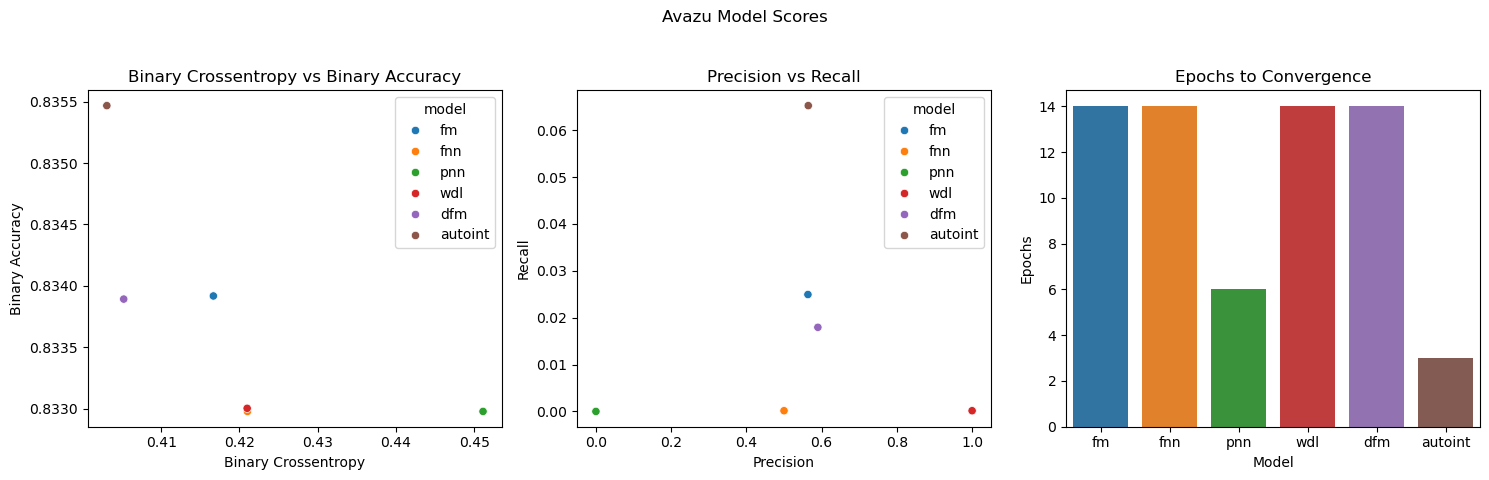

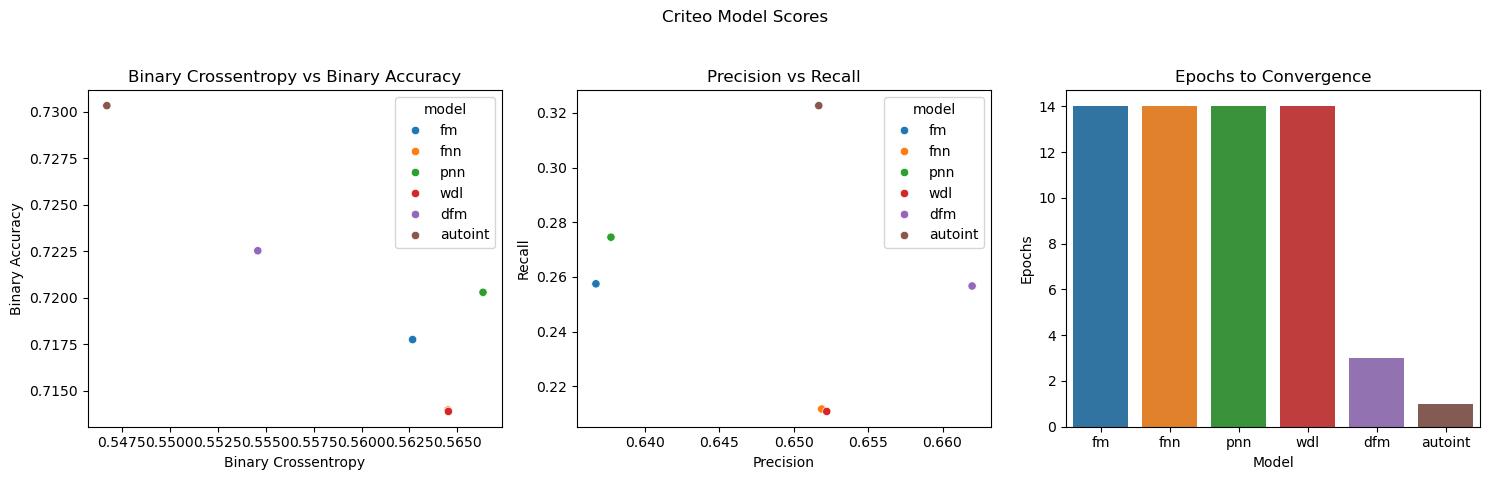

In [120]:
# Do the same except without the LR model

# Plot the the model scores by data set

for dataset in datasets:
    df = pd.read_csv(f'logs/{dataset}_model_scores.csv')
    df = df[df['model']!='lr']
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{dataset.capitalize()} Model Scores')
    
    # Plot a scatter plot of binary crossentropy loss vs binary accuracy
    sns.scatterplot(ax=axs[0], data=df, x='val_binary_crossentropy', y='val_binary_accuracy', hue='model', palette='tab10')
    axs[0].set_title('Binary Crossentropy vs Binary Accuracy')
    axs[0].set_xlabel('Binary Crossentropy')
    axs[0].set_ylabel('Binary Accuracy')

    # Plot a scatter plot of Precision vs Recall
    sns.scatterplot(ax=axs[1], data=df, x='val_precision', y='val_recall', hue='model', palette='tab10')
    axs[1].set_title('Precision vs Recall')
    axs[1].set_xlabel('Precision')
    axs[1].set_ylabel('Recall')

    # Plot a bar chart of epoch number by model
    sns.barplot(ax=axs[2], data=df, x='model', y='epoch', palette='tab10')
    axs[2].set_title('Epochs to Convergence')
    axs[2].set_xlabel('Model')
    axs[2].set_ylabel('Epochs')

    # Arrange the subplots so that the axis labels do not overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot
    #plt.savefig(f'figures/{dataset}_model_scores.png')
    plt.show()

# Deep Reinforcement Learning for Ad Personalization

In [ ]:
# Rebuild the kdd12 dfm model from the saved weights
## Create lists of categorical colums for each dataset
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

# Import categorical feature mappings and define stringloohup objects for each dataset
kdd12_vocab_sizes = {}
for field in kdd12_categorical_columns:
    df = pd.read_csv(f'./data/kdd12/categorical_value_counts/{field}.csv')
    vocab_size = len(df['field'])+1
    kdd12_vocab_sizes.update({field:vocab_size})

# Define numerical feature columns
kdd12_numerical_columns = [
    'Depth',
    'Position',
    'Impression'
]

## Define feature mappings
kdd12_fixlen_feature_columns = [SparseFeat(feat.lower(), vocabulary_size=kdd12_vocab_sizes[feat], embedding_dim=4) for feat in kdd12_categorical_columns]\
+ [DenseFeat(feat.lower(),1) for feat in kdd12_numerical_columns]

## Generate the dnn and linear feature columns
kdd12_dnn_feature_columns = kdd12_fixlen_feature_columns
kdd12_linear_feature_columns = kdd12_fixlen_feature_columns


In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
precision = Precision(thresholds=0.5,name='precision')
recall = Recall(thresholds=0.5,name='recall')

# Compile the DeepFM models
kdd12_dfm_model = DeepFM(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_dropout=0.6,
    dnn_hidden_units=[200,200,200],
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
)
kdd12_dfm_model.compile(adam_optimizer, "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

In [ ]:
kdd12_dfm_model.load_weights('models/dfm/kdd12/kdd12_dfm.ckpt')

In [ ]:
weights = kdd12_dfm_model.get_weights()

In [ ]:
kdd12_dfm_model.layers[0].get_weights()

# References

TBD